# Introduction
  In Reddit, there is a subreddit called WallStreetBets (r/wallstreetbets) where participants discuss stock and option trading. This subreddit went viral because it caused a significant fluctuation in the stock prices of GameStop in January 2021.
  
We obtained the dataset around that time from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts) to analysis the relationship between the post and stock price and also perform sentiment analysis.

In addtion, we obtain the dataset by ourselves with [Praw](https://github.com/praw-dev/praw) package in Python on r/wallstreetbets. The dataset included the recent post (Novembere 2023) and some hottest post in 2023.

# The required packages

In [1]:
import pandas as pd
import re
import os
import openai
from time import sleep
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yfinance as yf
from collections import Counter
## for plot
from datetime import datetime, timedelta, timezone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.io as pio
import praw
# correlation
import scipy
import operator
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/thl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function in Use

The `get_post_freq` function returns a Dataframe that summary the post frequency of given DataFrame into the `timestamp` and `frequency` columns. The frequency shows the number of posts in [`timestamp`, `timestamp` + `interval`). 

In [2]:
def get_post_freq(timestamps, interval: timedelta, start_time: datetime = None, end_time: datetime = None) -> pd.DataFrame:
    datetime_list = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in sorted(timestamps)] # convert string to datetime
    if len(datetime_list) == 0:
        return pd.DataFrame(columns=["timestamp", "frequency"])
    if start_time == None:
        start_time = datetime_list[0]
    if end_time == None:
        end_time = datetime_list[-1] + timedelta(seconds=1)
        
    datetime_list = [elem for elem in datetime_list if elem >= start_time and elem < end_time] # choose timestamps in the range from start_time to end_time
    datetime_list = [(elem - start_time) // interval for elem in datetime_list] # assign each timestamps to each interval
    datetime_list = [start_time + interval * elem for elem in datetime_list] # restore the real timestamps of each interval
    freq_list = list(Counter(datetime_list).items()) # aggregate timestamps into each interval

    if freq_list[-1][0] < end_time - interval: # add end bound
        freq_list.append((end_time - interval, 0))
    if freq_list[0][0] > start_time: # add start bound
        freq_list.insert(0, (start_time, 0))
    
    for i in range(len(freq_list)-2, -1, -1): # add 0s into the interval between two real records
        if freq_list[i + 1][0] - freq_list[i][0] > 2 * interval:
            freq_list.insert(i + 1, (freq_list[i + 1][0] - interval, 0))
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
        elif freq_list[i + 1][0] - freq_list[i][0] == 2 * interval:
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
    
    freq_df = pd.DataFrame(freq_list, columns=["timestamp", "frequency"])
    return freq_df

In [3]:
def plot_post_freq(df, interval = 1):
    interval = timedelta(days=interval)
    freq_df = get_post_freq(df["timestamp"], interval)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=freq_df["timestamp"],
        y=freq_df["frequency"],
        xperiod=interval.total_seconds()*1000
    ))
    fig.update_layout(
        title_text=f"Post frequency",
        xaxis_title=f"timestamp (day)",
        yaxis_title="the number of post",
        # width=1000,
        # height=500,
    )
    fig.show()

# Prepare Dataset

## Dataset from Kaggle
Just download it from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts).

In [48]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")

Some basic information of dataset

title  score      id  \
19537  GameStop short Melvin Capital lost 53% in January    175  l9pgct   
43367  Still shorting GME on downticks during restric...   2236  md169q   
9120   Can and should WallStreetBets really create an...      1  l70tpa   

                                                     url  comms_num  \
19537  https://www.marketwatch.com/story/gamestop-sho...         45   
43367                https://i.redd.it/su08n0to27p61.png        329   
9120   https://www.reddit.com/r/wallstreetbets/commen...          3   

            created                                               body  \
19537  1.612166e+09                                                NaN   
43367  1.616716e+09                                                NaN   
9120   1.611879e+09  Is that even legal?\n\nI’d be willing to inves...   

                 timestamp  
19537  2021-02-01 09:50:00  
43367  2021-03-26 01:42:18  
9120   2021-01-29 02:09:29


   The number of row: 53187
   The number of column: 8
   The first timestamp: 2020-09-29 03:46:56
   The last timestamp: 2021-08-16 09:26:20



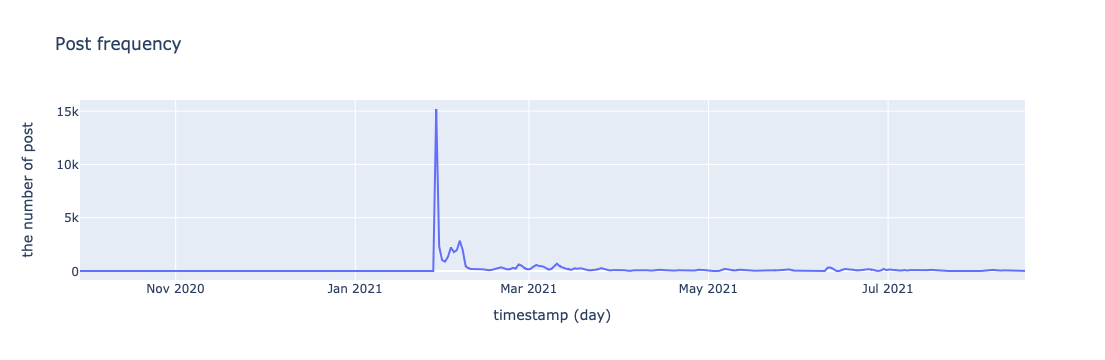

In [26]:
display(df_kaggle.sample(3))
info = f"""
   The number of row: {df_kaggle.shape[0]}
   The number of column: {df_kaggle.shape[1]}
   The first timestamp: {df_kaggle.sort_values(["created"])["timestamp"].values[0]}
   The last timestamp: {df_kaggle.sort_values(["created"])["timestamp"].values[-1]}
"""
print(info)
plot_post_freq(df_kaggle)

## Recent Dataset around November 2023

Use Praw package to obtain the data from Reddit API.

In [6]:
# The same columns as the kaggle dataset
df_2023 = pd.DataFrame(columns = ['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp'])

In [24]:
# User's credential
reddit = praw.Reddit(
    client_id="VjQhhXD0WiNzaBsUBcOXsQ",
    client_secret="ZIwQQo6_2mJ16woXKFPiE3-ArYOxug",
    user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
)

# The target subreddit is "r/wallstreetbets"
subreddit = reddit.subreddit("wallstreetbets")

# Reddit limits it to 1000 so their servers don't die.
limit = 1000
for g in [subreddit.new(limit=limit), subreddit.top(limit=limit), subreddit.hot(limit=limit), subreddit.rising(limit=limit)]:
    for submission in g:
        data = {
            "title": submission.title,
            "score": submission.score,
            "id": submission.id,
            "url": submission.url,
            "comms_num": submission.num_comments,
            "created": submission.created_utc,
            "body": submission.selftext,
            "timestamp": datetime.fromtimestamp(submission.created_utc, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        }
        df_2023.loc[len(df_2023)] = data

In [ ]:
# Drop duplicated data
df_2023 = df_2023.drop_duplicates(["id"], ignore_index = True)

# Only included the data in year 2023
df_2023 = df_2023[df_2023["created"] >= datetime.timestamp(datetime(2023, 1, 1, tzinfo=timezone.utc))].reset_index(drop = True)
df_2023 = df_2023.sort_values(["created"], ignore_index = True)

It might take a little time to grab the data. We have already run the above code beforehand and store the dataset in `./dataset/reddit_wsb_2023.csv`. Just load it to save your time.

In [28]:
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

Some basic information of dataset

title  score       id  \
846  Sold TSLA calls at the peak this morning, +$22...    131  18bj0mo   
55                     $1.2k —> $10.7k thanks to $TSLA    519  17z23qx   
405                                         Tesla Puts   3131  18521al   

                                        url  comms_num       created  \
846     https://i.redd.it/nxz8xx4oui4c1.jpg         36  1.701802e+09   
55   https://www.reddit.com/gallery/17z23qx         69  1.700415e+09   
405     https://i.redd.it/bs4dg653yv2c1.jpg        320  1.701089e+09   

                                                  body            timestamp  
846                                                NaN  2023-12-05 18:44:22  
55   Buying dips, selling rips and shorting pullbacks.  2023-11-19 17:26:42  
405                                           Ok noted  2023-11-27 12:38:26


   The number of row: 919
   The number of column: 8
   The first timestamp: 2023-01-04 09:50:17
   The last timestamp: 2023-12-06 18:23:46



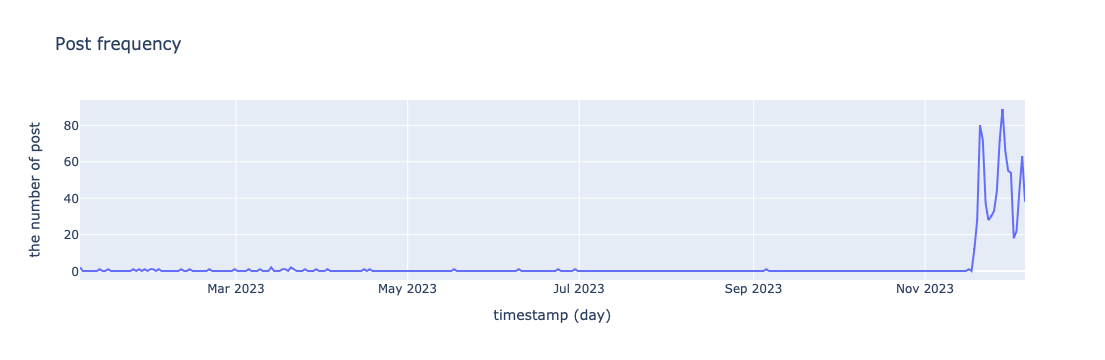

In [29]:
display(df_2023.sample(3))
info = f"""
   The number of row: {df_2023.shape[0]}
   The number of column: {df_2023.shape[1]}
   The first timestamp: {df_2023.sort_values(["created"])["timestamp"].values[0]}
   The last timestamp: {df_2023.sort_values(["created"])["timestamp"].values[-1]}
"""
print(info)
plot_post_freq(df_2023)

# Research Question 1

<b>What are the immediate effects on stock prices of companies mentioned in highly upvoted or viral posts on platforms like WallStreetBets?</b>

To solve this question, we first start with find out the ticker symbol in the context. We have two approachs:<br/>
- <b>Method1:</b> Extract the captialize words in the post.
- <b>Method2:</b> Use openai API to extract the ticker symbol in the context.
<br/>

For both methods, we have to clean up the dataset beforehand.

## Pre-processing

In [87]:
def remove_hyperlink(body):
    body = re.sub(r'https?://\S+|www\.\S+', '', body)
    # body = re.sub(r'/\S/\S+', '', body)
    return body

def remove_punctuation(body):
    punctuation = '!"#%&\()*+,-.:;<=>?@[\\]^_`{|}~'
    body = re.sub(rf'[{punctuation}\\\s]+', " ", body)
    return body

In [88]:
def data_preprocessing(df):
    df["body"].fillna(value = "", inplace = True)
    df["body"] = df["title"] + ": "+ df["body"]
    df["body"] = df["body"].apply(remove_hyperlink)
    df["body"] = df["body"].apply(remove_punctuation)

In [51]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

## Method1: Extract the capitalize words in the post

In [9]:
stopwords_set = set([i.upper() for i in stopwords.words("english")] + [i for i in stopwords.words("english")])
def remove_stopword(body):
    words = set(body.split(" "))
    words = words - stopwords_set
    return " ".join(words)

def find_potential_ticker_symbol(body):
    return set(re.findall(r'\b[A-Z]+\b', body))

In [10]:
def find_top_n_ticker_symbol(df, n = 10):
    df["ticker symbol"] = df["body"]
    df["ticker symbol"] = df["ticker symbol"].apply(remove_stopword)
    df["ticker symbol"] = df["ticker symbol"].apply(find_potential_ticker_symbol)
    # find potential ticker symbol
    potential_ticker_symbol_freq = Counter({})
    for i in df["ticker symbol"]:
        potential_ticker_symbol_freq += Counter({k:1 for k in i})

    # find top n ticker symbol
    cnt = 0
    ticker_symbol_top_n = []
    potential_ticker_symbol_sort = [i[0] for i in potential_ticker_symbol_freq.most_common(len(potential_ticker_symbol_freq))]
    for i in potential_ticker_symbol_sort:
        if cnt == n:
            break
        ticker = yf.Ticker(i)
        # _ = ticker.info
        out = ticker.history()
        if out.shape[0]:
            ticker_symbol_top_n.append(i)
            print(f"{i} is a ticker symbol")
            cnt += 1
            
    # Propagation        
    company_name = [yf.Ticker(i).info['longName'].split(" ")[0].upper() for i in ticker_symbol_top_n]
    name_ticker_map = pd.DataFrame([ticker_symbol_top_n], columns = company_name)
    for i in range(df.shape[0]):
        body_set = set(df.loc[i, "body"].upper().split(" "))
        df.at[i, "ticker symbol"] = df.loc[i, "ticker symbol"] | ( (body_set & set(ticker_symbol_top_n) ) | set(name_ticker_map.loc[0, list(body_set & set(company_name))].values))
        
    # If appear in post show "True", if not show "False"
    df.loc[:,ticker_symbol_top_n] = False
    # if appear set True
    for i in range(df.shape[0]):
        df.loc[i, list(df.loc[i, "ticker symbol"] & set(ticker_symbol_top_n))] = True

    return ticker_symbol_top_n

In [69]:
ticker_symbol_top_n_kaggle = find_top_n_ticker_symbol(df_kaggle, 10)
ticker_symbol_top_n_kaggle

GME is a ticker symbol


I: No data found, symbol may be delisted


AMC is a ticker symbol
DD is a ticker symbol


WSB: No price data found, symbol may be delisted (period=1mo)
HOLD: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)


YOLO is a ticker symbol
BB is a ticker symbol


BUY: No price data found, symbol may be delisted (period=1mo)
TLDR: No price data found, symbol may be delisted (period=1mo)


NOK is a ticker symbol
RH is a ticker symbol


SEC: No price data found, symbol may be delisted (period=1mo)
CEO: No data found, symbol may be delisted
FUCKING: No data found, symbol may be delisted
P: No price data found, symbol may be delisted (period=1mo)
DR: No price data found, symbol may be delisted (period=1mo)


MOON is a ticker symbol


TL: Period '1mo' is invalid, must be one of ['1d', '5d']
SELL: No data found, symbol may be delisted


PLTR is a ticker symbol
EDIT is a ticker symbol


['GME', 'AMC', 'DD', 'YOLO', 'BB', 'NOK', 'RH', 'MOON', 'PLTR', 'EDIT']

According to the output, we obtain the top 10 ticker symbols: 
1. GME
2. AMC
3. DD
4. YOLO
5. BB
6. NOK
7. RH
8. MOON
9. PLTR
10. EDIT

In [70]:
ticker_symbol_top_n_2023 = find_top_n_ticker_symbol(df_2023, 10)
ticker_symbol_top_n_2023 

I: No data found, symbol may be delisted
CEO: No data found, symbol may be delisted
WSB: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)
P: No price data found, symbol may be delisted (period=1mo)


AI is a ticker symbol
NVDA is a ticker symbol
MSFT is a ticker symbol


ETF: No price data found, symbol may be delisted (period=1mo)


U is a ticker symbol
SPY is a ticker symbol
DM is a ticker symbol
SAVE is a ticker symbol
E is a ticker symbol
YOLO is a ticker symbol
DD is a ticker symbol


['AI', 'NVDA', 'MSFT', 'U', 'SPY', 'DM', 'SAVE', 'E', 'YOLO', 'DD']

According to the output, we obtain the top 10 ticker symbols: 
1. AI
2. NVDA
3. MSFT
4. U
5. SPY
6. DM
7. SAVE
8. E
9. YOLO
10. DD

### sentiment analysis

In [71]:
def sentiment_anaysis(df, top_n_ticker_symbol):
    def categorize_sentiment(score):
        if score > 0:
            return 1
        elif score < 0:
            return 2
        else:
            return 0
    sia = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound']).apply(categorize_sentiment)
    df[top_n_ticker_symbol] = df[top_n_ticker_symbol].astype('float')
    for ticker in top_n_ticker_symbol:
        df.loc[df[ticker] == 0, ticker] = pd.NA
        df.loc[df[ticker] == 1, ticker] = df.loc[df[ticker] == 1, 'sentiment_score']

In [72]:
sentiment_anaysis(df_kaggle, ticker_symbol_top_n_kaggle)

In [73]:
sentiment_anaysis(df_2023, ticker_symbol_top_n_2023)

### Plot the stock price and the appear frequence of ticker symbol

In [55]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    df = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Open"],
            name = f"Stock open",
            marker=dict(color="#00CC96")
        )
    )
    
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Volume"],
            name = f"Stock volume",
            yaxis="y2",
            marker=dict(color="#636EFA")
        )
    )
    
    fig.add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color="#FFA15A")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color="red")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.8,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color="purple")
    ))


    # Create axis objects
    fig.update_layout(
        yaxis=dict(
            title=f"Stock Open",
            titlefont=dict(
                color="#00CC96"
            ),
            tickfont=dict(
                color="#00CC96"
            )
        ),
        yaxis2=dict(
            title=f"Stock Volume",
            titlefont=dict(
                color="#636EFA"
            ),
            tickfont=dict(
                color="#636EFA"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            autoshift=True,
            shift=-50,
        ),
        yaxis3=dict(
            title="The number of post",
            anchor="x",
            overlaying="y",
            side="right",
        ),
    )
    fig.update_layout(barmode='stack')
    # Update layout properties
    fig.update_layout(
        title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
        width=1000,
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        )
    )

    fig.show()

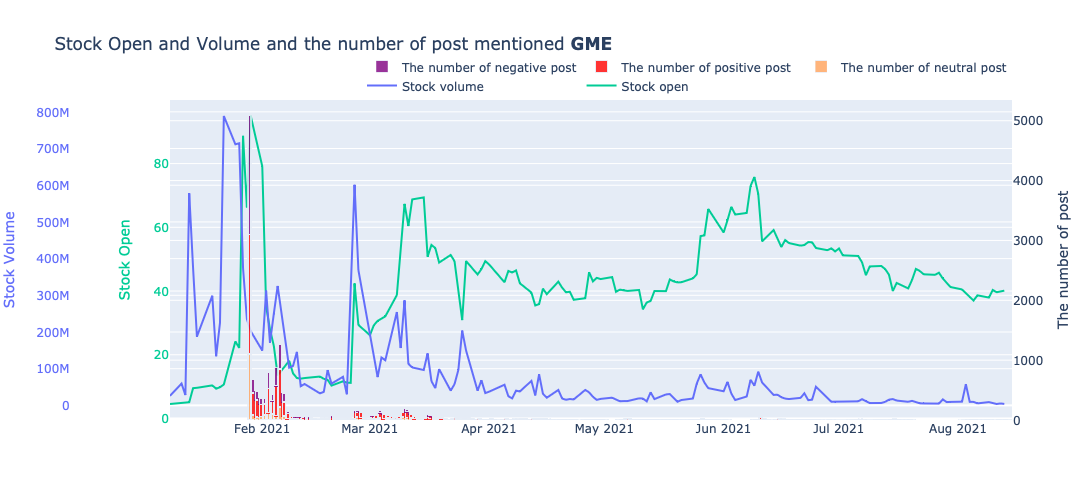

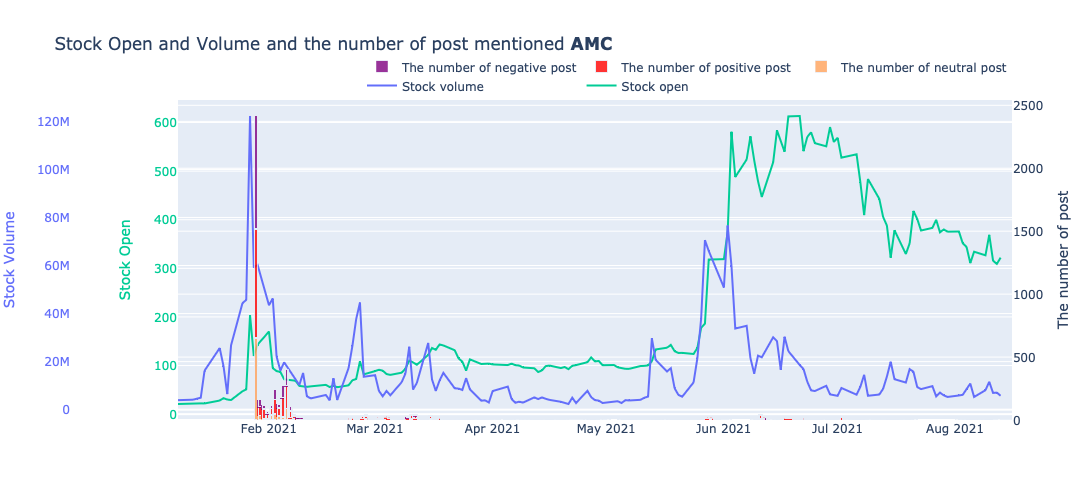

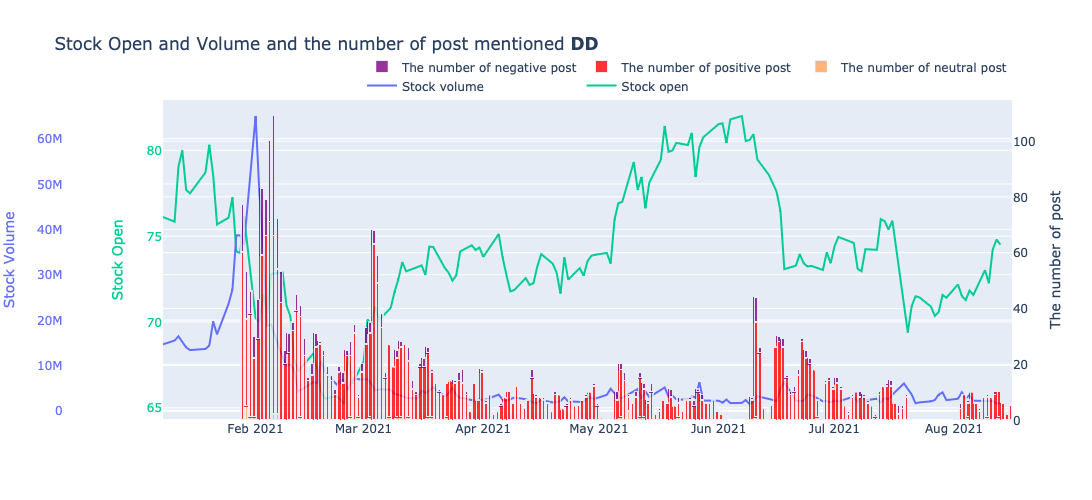

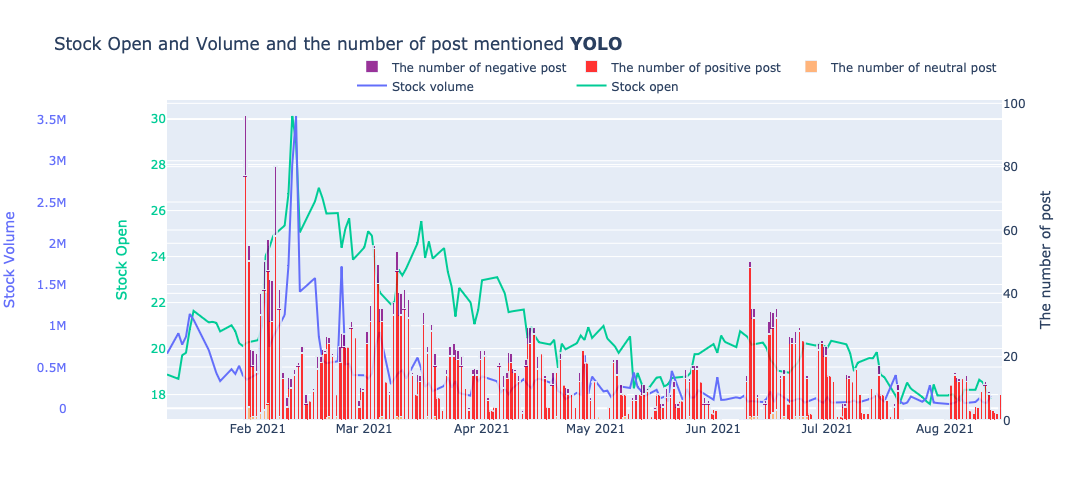

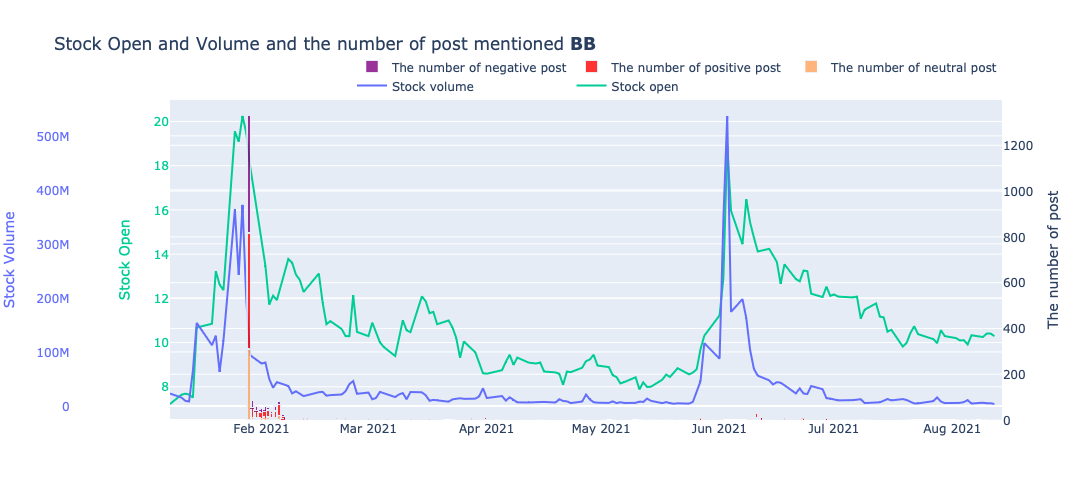

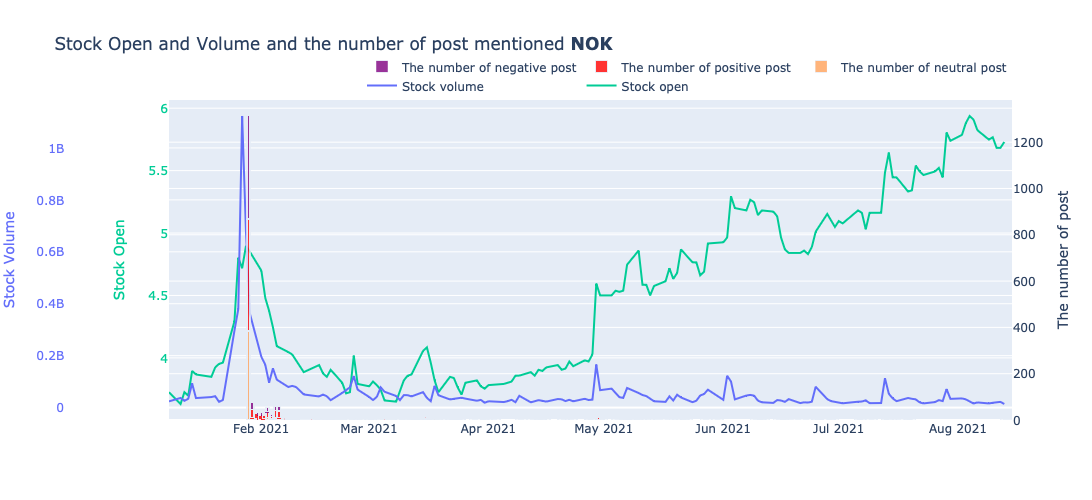

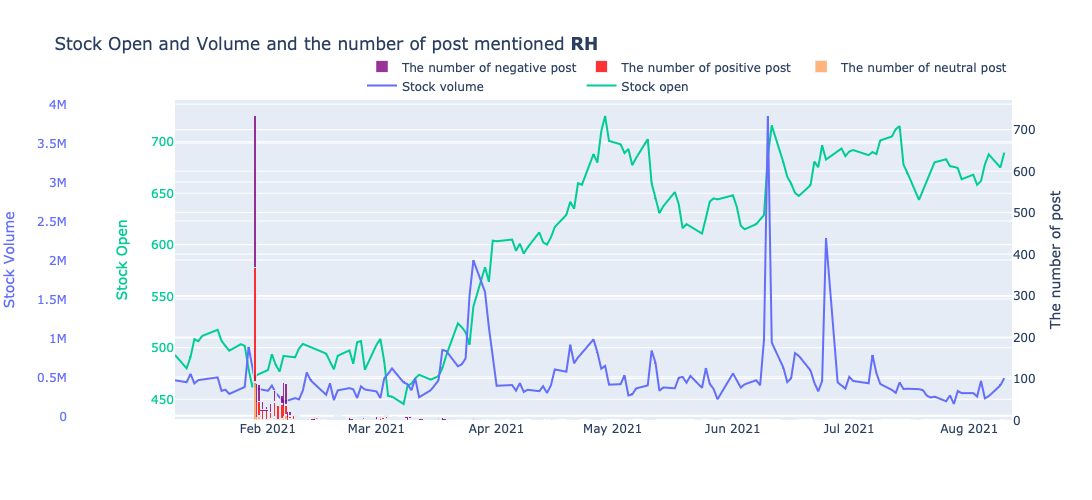

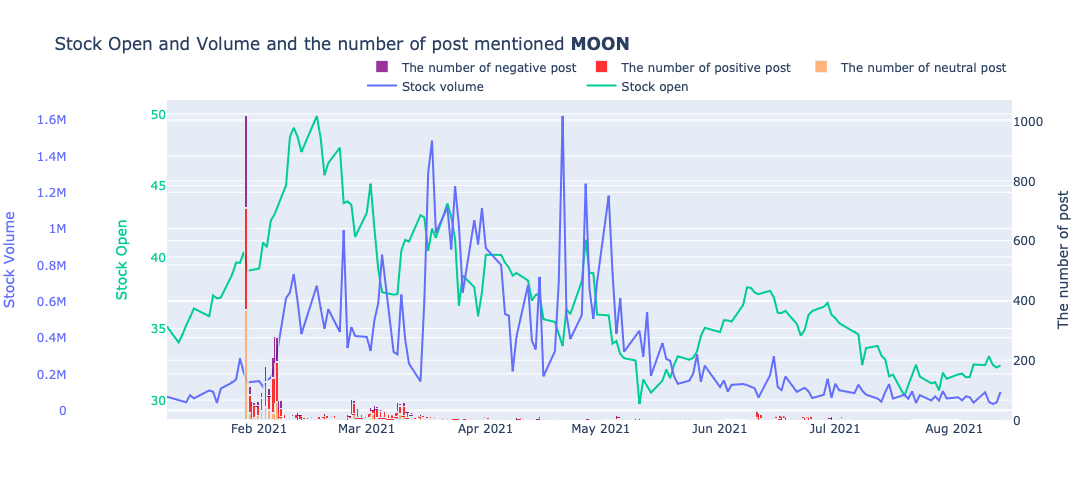

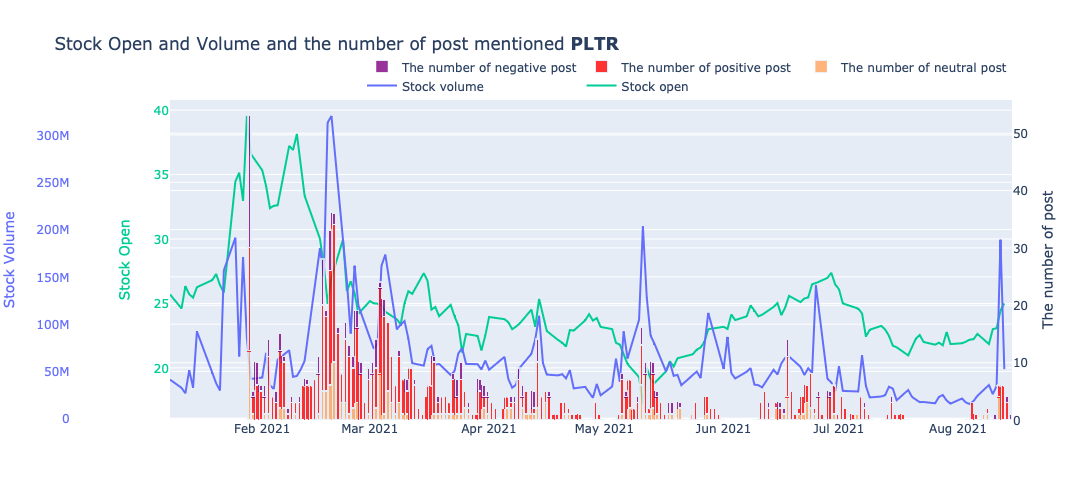

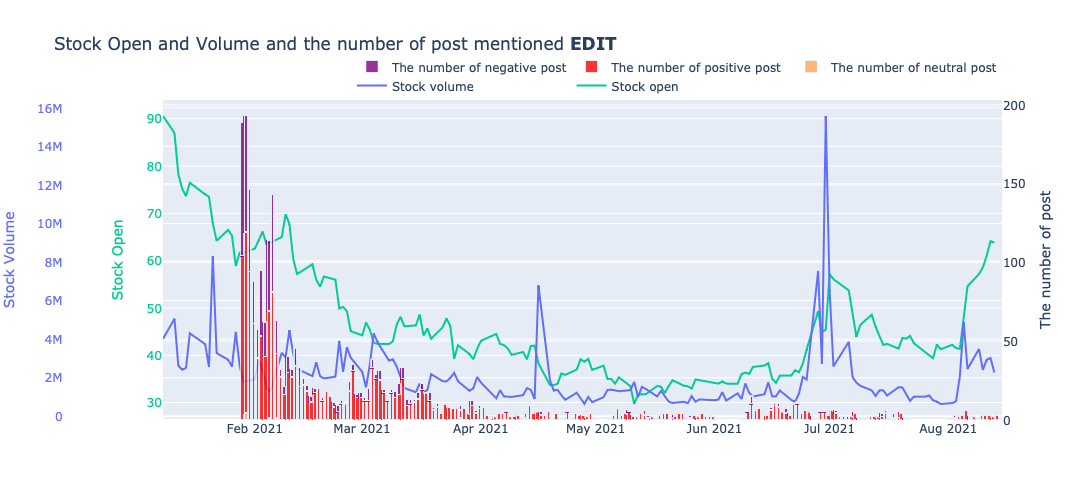

In [75]:
for ticker_symbol in ticker_symbol_top_n_kaggle:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

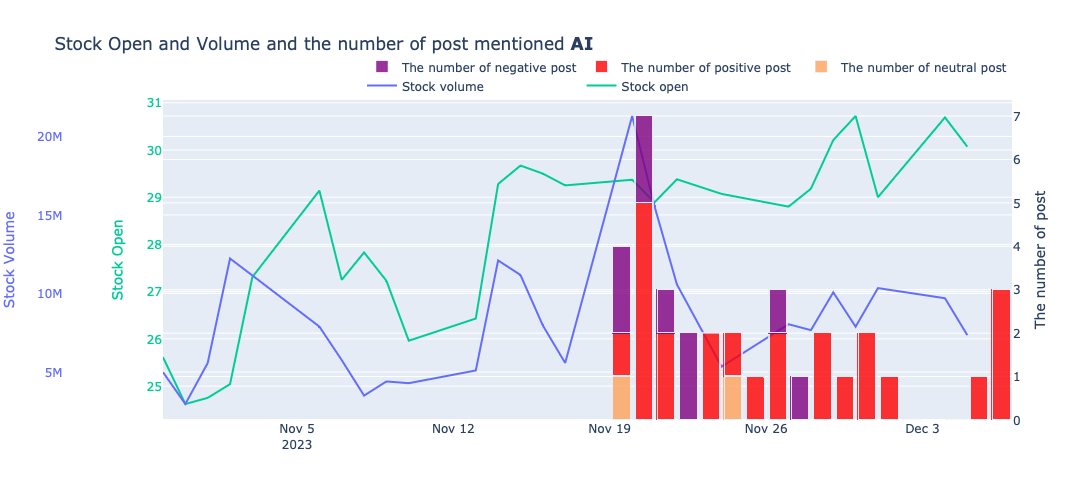

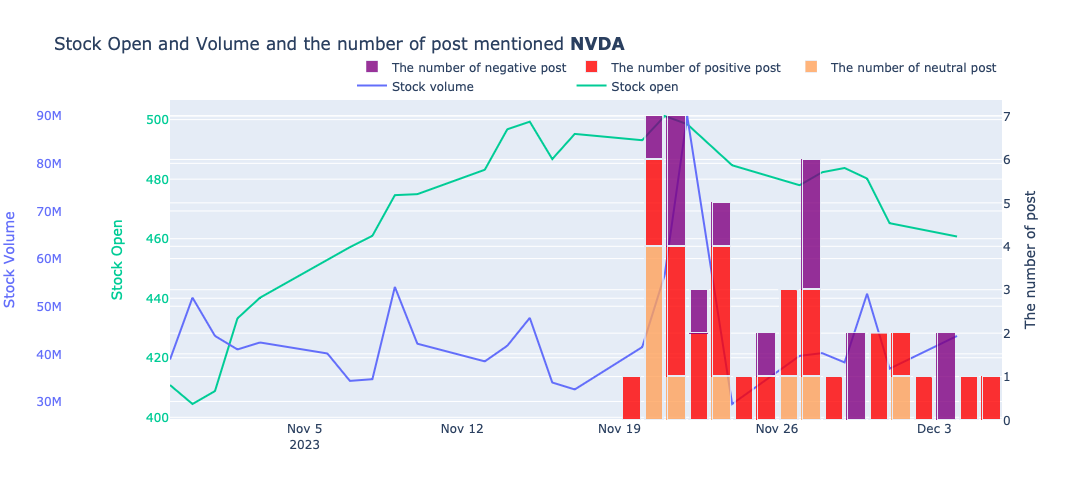

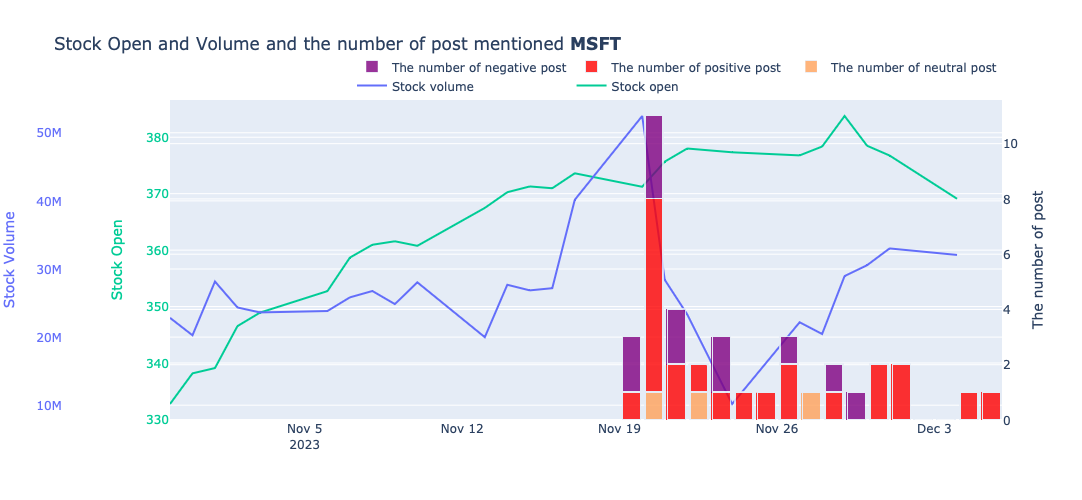

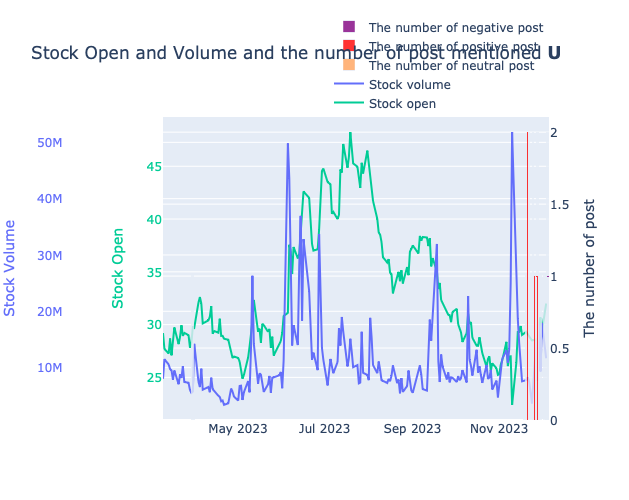

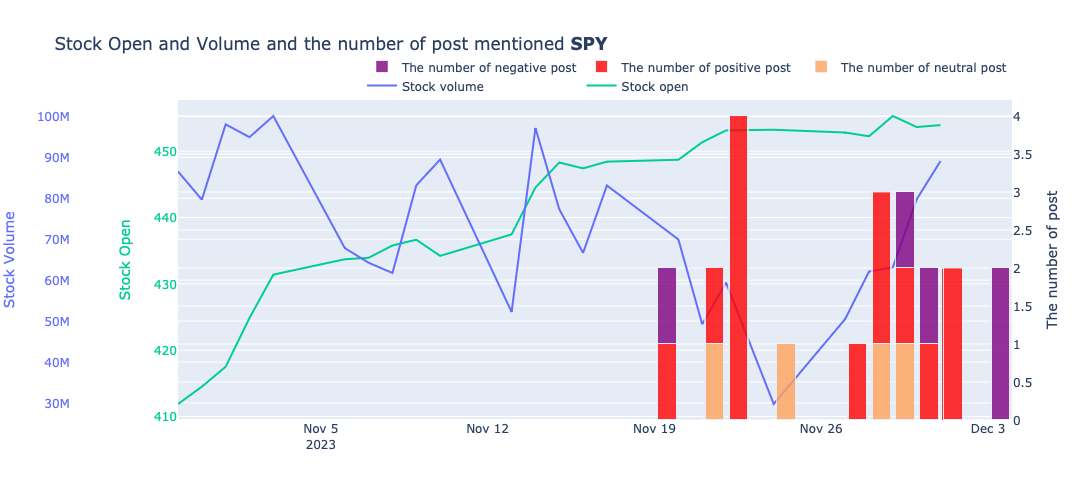

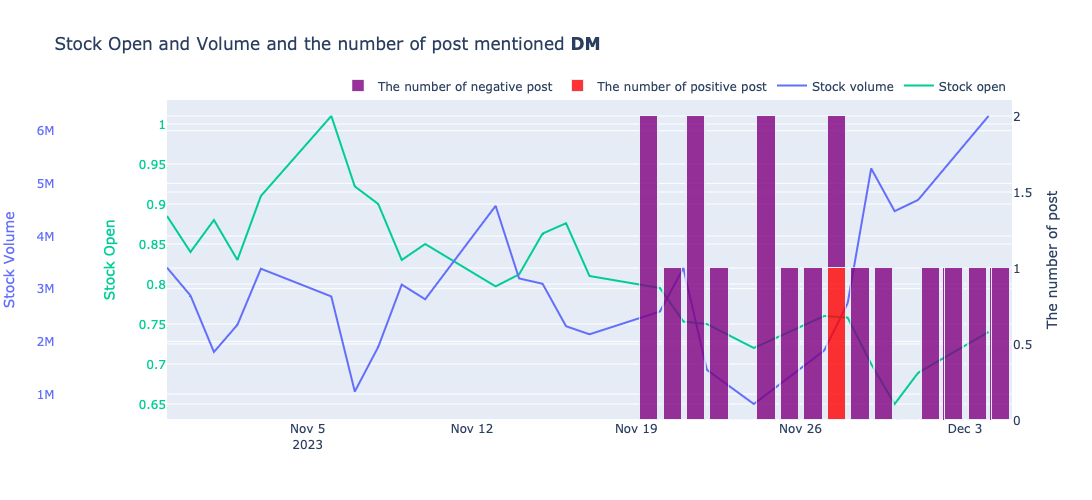

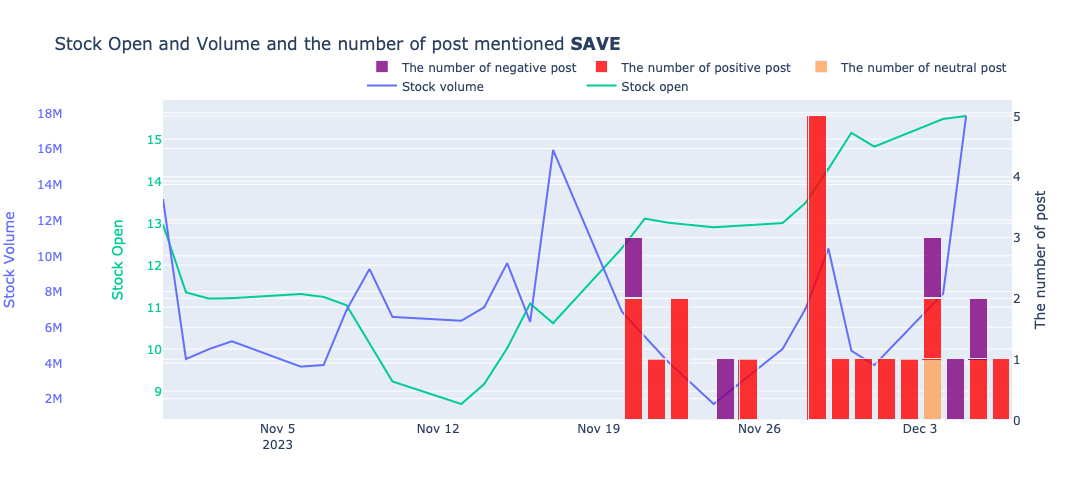

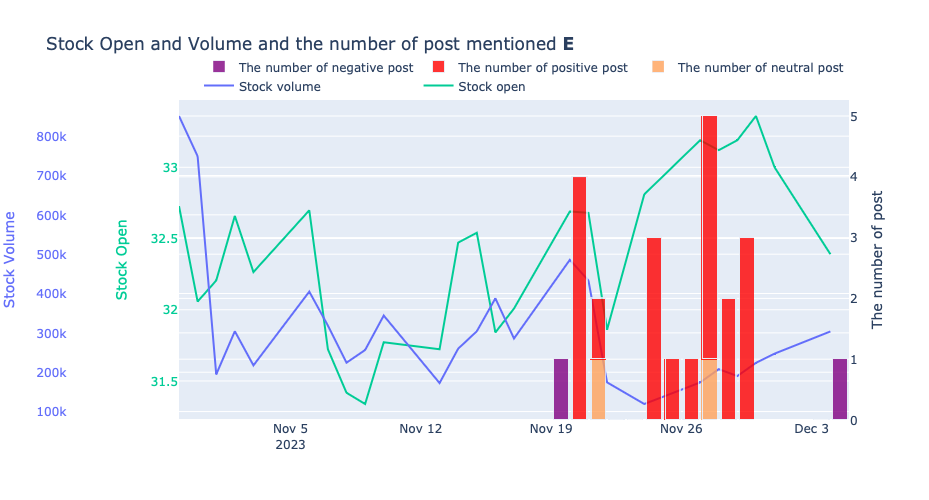

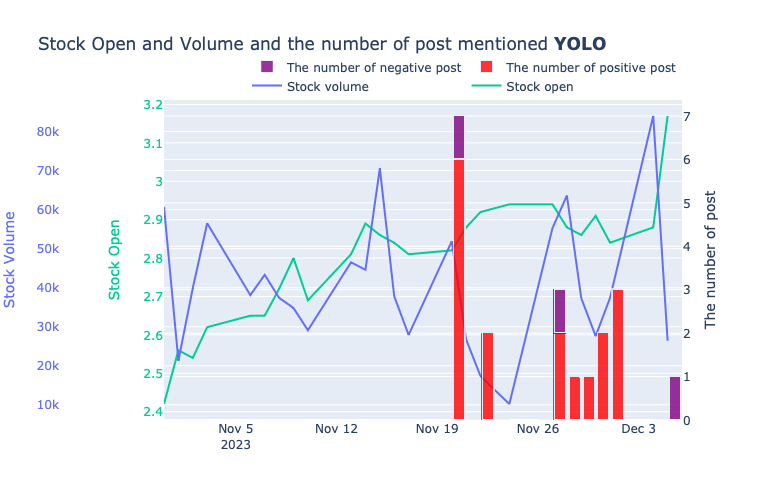

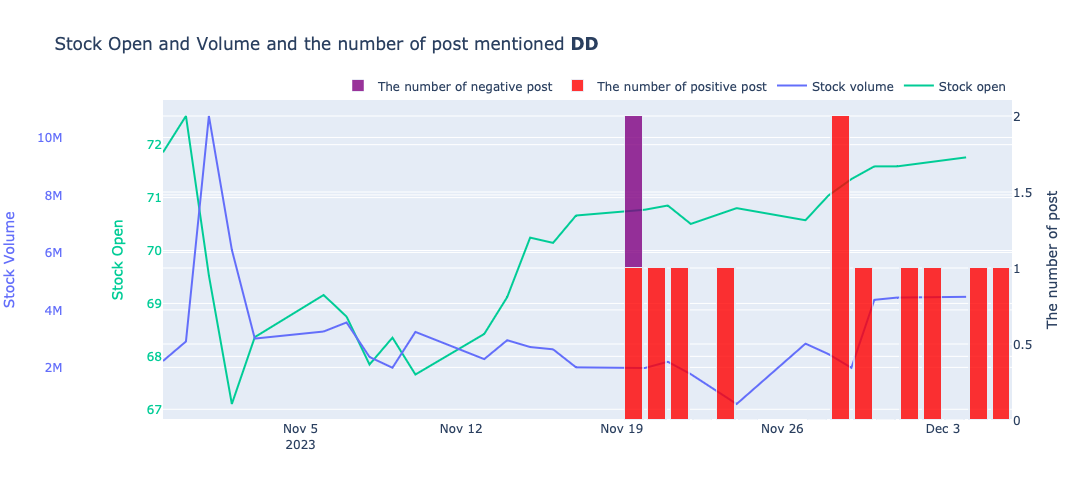

In [76]:
for ticker_symbol in ticker_symbol_top_n_2023:
    plot_stock_and_post_freq(df_2023, ticker_symbol)

## Method2: Use openai API to extract the ticker symbol in the context.

In [89]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

In [90]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

### Send the body of post to ChatGPT

As openai API is not free, we only choose the post which its number of comment is above certain threshold. Also, there is [rate limits](https://platform.openai.com/docs/guides/rate-limits/usage-tiers?context=tier-free) on openai API for free tier users, so we cannot send our request all at once.

In [93]:
def request_ticker_sentiment_gpt(df, api_key, start = 0, end = 15):
    openai.api_key = api_key
    question = '''
        Give me list of ticker symbols with indication mentioned in the each of context. 
        If not give me "NULL". Also, show the "Rise" or "Drop" or "NULL" of each ticker 
        symbols based on the context. The output should be a list of ticker symbols with 
        rise or drop indication. Only show the output list, and do not show other extra 
        word. For example, the output is like 1. {"GME": "Rise", "NOK": NULL} 2. {"NOK": "Drop"}: 
        '''

    # 'step' means the number of post per request
    step = original_step = min(end - start, 15)
    
    # 'backoff_step' means reduce how many post per request, 'backoff_limit' means the maximal retry time
    backoff_step, backoff_limit = 4, 10
    post_idx = start
    while post_idx < end and step > 0:
        print(f"Sending posts {post_idx} to {post_idx + step} ({step} post per request)...")
        
        body = ""
        for j in range(step):
            body = body + f"\n\n{j + 1}. {df.loc[post_idx + j, 'body']}"
            
        messages = [
            {"role": "system", "content": "You are a stock analyst"},
            {"role": "user", "content": question + body}
        ]
        
        for j in range(backoff_limit):
            try:
                completion = openai.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages = messages
                )
                errno = 0
                break
            except openai.BadRequestError:
                print("Bad Request: request exceed token limit")
                errno = 2
                break
            except:
                print(f"Request failed, retry {j}/{backoff_limit}")
                sleep(60 * (j+1))
                errno = 1

        resp = completion.choices[0].message.content.split("\n")
        if len(resp) != step:
            print("Bad Response: the length of response mismatch request")
            errno = 3

        if errno == 1:
            print(f"Process stop at post {post_idx}")
            break
        elif errno == 2:
            # reduce the amount of send message
            print(f"Reduce the number of post per request from {step} to {step - backoff_step}")
            step -= backoff_step
            continue
        elif errno == 3:
            # unknown error, skip the post cause error
            print(f"Skiping posts {post_idx} to {post_idx} ")
            step = original_step
            post_idx += step
            continue
            
        df.loc[post_idx:(post_idx + step - 1), "response"] = pd.Series(resp, index = [k for k in range(post_idx, post_idx+step)])
        print(f"Sucessfully obtain response of post {post_idx} to {post_idx + step}:")
        display(df.loc[post_idx:(post_idx + step - 1), "response"])
        # wait about 1 minitue to send next request to prevent exceed rate limit
        sleep(70)
    
        post_idx += step
        step = original_step

We only pick the 'hot' posts to do analysis to fit in budget (OpenAI API is not free).

The data from kaggle is too much, so we pick the post that have more than 600 comments as analysis targets.

In [67]:
# Do the most comms post first
comms_num_threshold = 600
df_kaggle = df_kaggle.sort_values(by = ["comms_num"], ascending=False, ignore_index = True)
df_kaggle = df_kaggle[df_kaggle["comms_num"] > comms_num_threshold]

To demostrate the code is working, we send the post 0 to post 30 for demonstration purpose. If you want to send the whole dataset, you can set `end_post_idx = df_kaggle.shape[0]`. But remember that the OpenAI API is not free, sending whole dataset might cost some credit.

In [68]:
start_post_idx = 0
end_post_idx = 30
request_ticker_sentiment_gpt(df_kaggle, api_key = "*****", start = start_post_idx, end = end_post_idx)

Sending posts 0 to 15 (15 post per request)...
Sucessfully obtain response of post 0 to 15:


0      1. GME: NULL
1           2. NULL
2      3. GME: NULL
3           4. NULL
4      5. GME: NULL
5      6. GME: NULL
6      7. GME: NULL
7           8. NULL
8      9. GME: NULL
9     10. GME: NULL
10         11. NULL
11    12. GME: NULL
12    13. GME: NULL
13         14. NULL
14    15. GME: NULL
Name: response, dtype: object

Sending posts 15 to 30 (15 post per request)...
Sucessfully obtain response of post 15 to 30:


15     1. {"GME": "Rise"}
16     2. {"GME": "Rise"}
17     3. {"GME": "Rise"}
18                4. NULL
19     5. {"GME": "Rise"}
20     6. {"GME": "Rise"}
21                7. NULL
22                8. NULL
23     9. {"GME": "Rise"}
24    10. {"GME": "Rise"}
25               11. NULL
26    12. {"GME": "Rise"}
27               13. NULL
28    14. {"GME": "Rise"}
29               15. NULL
Name: response, dtype: object

<br><br>
The data from 2023 is not much, so we use all. But also just run first 30 post for demostration

In [94]:
start_post_idx = 0
end_post_idx = 30
request_ticker_sentiment_gpt(df_2023, api_key = "*****", start = start_post_idx, end = end_post_idx)

Sending posts 0 to 15 (15 post per request)...
Sucessfully obtain response of post 0 to 15:


0      1. {"TSLA": "NULL"}
1              2. {"NULL"}
2              3. {"NULL"}
3              4. {"NULL"}
4     5. {"GOOGL": "NULL"}
5              6. {"NULL"}
6              7. {"NULL"}
7      8. {"ABNB": "NULL"}
8              9. {"NULL"}
9             10. {"NULL"}
10    11. {"NFLX": "NULL"}
11            12. {"NULL"}
12      13. {"FB": "NULL"}
13            14. {"NULL"}
14    15. {"UBER": "NULL"}
Name: response, dtype: object

Sending posts 15 to 30 (15 post per request)...
Sucessfully obtain response of post 15 to 30:


15                      1. {"NULL"}
16                      2. {"NULL"}
17                      3. {"NULL"}
18                      4. {"NULL"}
19                      5. {"NULL"}
20               6. {"SBF": "NULL"}
21                      7. {"NULL"}
22                      8. {"NULL"}
23                      9. {"NULL"}
24    10. {"Credit Suisse": "NULL"}
25                     11. {"NULL"}
26                     12. {"NULL"}
27                     13. {"NULL"}
28                     14. {"NULL"}
29                     15. {"NULL"}
Name: response, dtype: object

No matter what running for full dataset is time-consuming. Use this dataset to continue the task!

In [109]:
df_kaggle = pd.read_csv("./dataset/intermediate_dataset/gpt_response_kaggle.csv")
df_2023 = pd.read_csv("./dataset/intermediate_dataset/gpt_response_2023.csv")

### Clean up the response data from ChatGPT

In [6]:
df_kaggle.head(3)

title  score      id  \
0                  GME Megathread for March 10, 2021  47667  m1xhlc   
1       Daily Discussion Thread for January 29, 2021  12288  l7ptxi   
2  GME Megathread for Wednesday, February 24th, 2021  28975  lre2k6   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/wallstreetbets/commen...      93268  1.615412e+09   
1  https://www.reddit.com/r/wallstreetbets/commen...      89050  1.611947e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...      83094  1.614205e+09   

                                                body            timestamp  \
0  GME Megathread for March 10 2021 HOLYMOLYHOLYM...  2021-03-10 23:30:11   
1  Daily Discussion Thread for January 29 2021 Yo...  2021-01-29 21:00:15   
2  GME Megathread for Wednesday February 24th 202...  2021-02-25 00:24:58   

             response  
0  1. {"GME": "Rise"}  
1         2. {"NULL"}  
2  3. {"GME": "Rise"}

In [45]:
df_2023.head(3)

title  score       id  \
0  Weekend Discussion Thread for the Weekend of D...     77  188mca2   
1      Daily Discussion Thread for December 01, 2023     83  18896j3   
2      Daily Discussion Thread for November 30, 2023     80  187fyqf   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/wallstreetbets/commen...       9905  1.701465e+09   
1  https://www.reddit.com/r/wallstreetbets/commen...       7889  1.701428e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...       7275  1.701342e+09   

                                                body            timestamp  \
0  Weekend Discussion Thread for the Weekend of D...  2023-12-01 21:01:48   
1  Daily Discussion Thread for December 01 2023 J...  2023-12-01 11:01:25   
2  Daily Discussion Thread for November 30 2023 J...  2023-11-30 11:00:43   

      response  
0  1. {"NULL"}  
1  2. {"NULL"}  
2  3. {"NULL"}

As you can see, the response from ChatGPT is something like:
```
1. {"GME": "Rise", "NOK": NULL}
2. {"NOK": "Drop"}
3. NULL
...
```
we have to clean up those response into same format and set the ticker appeared in response as the new column. Under each ticker column, the post that mentioned the ticker will be set to corresponding sentiment value, which `NULL` set to `0`, `Rise` set to `1`, and `Drop` set to `2`. If the post do not mentioned the ticker, it will be set to `NULL` under that ticker column.

In [47]:
def format_gpt_response(df):
    def clean_response(body):
        if type(body) == str:
            body = re.sub(r'[\s"\'}{]+', "", body)
            body = re.sub(r'^[0-9]+\.', "", body)
        return body
    # clean response
    df["response"] = df["response"].apply(clean_response)

    # create new column for each ticker
    indication_map = {"null": 0, "rise": 1, "drop": 2}
    test_fail_set = set(["NULL"])
    for idx in range(df.shape[0]):
        if type(df.loc[idx, "response"]) != str:
            continue
        resp_list = df.loc[idx, "response"].split(",")
        for resp in resp_list:
            m = re.match(r"(\w+):?(\w*)", resp)
            if m is None:
                continue
            ticker_symbol = m.group(1).upper()
            indication = m.group(2).lower()
            # already found find it is invalid
            if ticker_symbol in test_fail_set:
                continue
            # add new ticker symbol
            if ticker_symbol not in df.columns:
                try:
                    # Check whether the ticker symbol exist
                    start = sorted(df["timestamp"])[0].split(" ")[0]
                    end = sorted(df["timestamp"])[-1].split(" ")[0]
                    out = yf.Ticker(ticker_symbol).history(start = df["timestamp"].values[0].split(" ")[0], end = df["timestamp"].values[-1].split(" ")[0])
                    if len(out) == 0:
                        raise
                    df[ticker_symbol] = None
                    print(f"Add {ticker_symbol}")
                except:
                    # the ticker symbol do not exist
                    test_fail_set.add(ticker_symbol)
                    continue
            # add indication
            if indication in indication_map:
                df.loc[idx, ticker_symbol] = indication_map[indication]
            else:
                df.loc[idx, ticker_symbol] = 0

In [216]:
format_gpt_response(df_kaggle)

Add GME
Add CLOV
Add CLNE
Add BB


GUH: Period '1mo' is invalid, must be one of ['1d', '5d']


Add TSLA


1R0NYMAN: No timezone found, symbol may be delisted
WSB: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add PRPL
Add MSFT
Add AAPL
Add DIS
Add RKT
Add AMC


COIN: Data doesn't exist for startDate = 1615352400, endDate = 1616990400


Add SLV
Add CRSR
Add DKNG
Add NOK


APHA: No timezone found, symbol may be delisted


Add TLRY
Add SPY
Add MVST
Add MRNA
Add WISH


BLACKBERRY: No timezone found, symbol may be delisted


Add WKHS


TESLA: No timezone found, symbol may be delisted
SEC: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add PLTR
Add BTC


ETH: No timezone found, symbol may be delisted
DOGE: No timezone found, symbol may be delisted
NAKD: No timezone found, symbol may be delisted


Add CRLBF
Add AG


CNBC: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)
BLOCKBUSTER: No timezone found, symbol may be delisted


Add MNMD


JIMCRAMER: No timezone found, symbol may be delisted
FIDELITY: No timezone found, symbol may be delisted
BLOOMBERG: No timezone found, symbol may be delisted
BOFA: No timezone found, symbol may be delisted


Add AMD
Add SOFI


ZAR: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add MVIS
Add EZA


GEE: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add CLF
Add SNDL
Add SPCE


DFV: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add UBER
Add SNAP
Add PTON


RISE: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add AMZN
Add LMT
Add RTX
Add BA


JPOW: No timezone found, symbol may be delisted
AMAZON: No timezone found, symbol may be delisted


Add RH


ROBINHOOD: No timezone found, symbol may be delisted


Add UWMC
Add SKLZ


DTCC: No timezone found, symbol may be delisted
WSJ: Period '1mo' is invalid, must be one of ['1d', '5d']
S3: No timezone found, symbol may be delisted
DOWJONES: No timezone found, symbol may be delisted
FTSE: No timezone found, symbol may be delisted
S: Data doesn't exist for startDate = 1615352400, endDate = 1616990400
BBBY: No timezone found, symbol may be delisted
EM: Data doesn't exist for startDate = 1615352400, endDate = 1616990400


Add ZOM
Add YOLO


MONSTER: No timezone found, symbol may be delisted


Add BIDU
Add IQ
Add TME


VIAC: No timezone found, symbol may be delisted
DISCA: No timezone found, symbol may be delisted


Add VIPS
Add YY


HOOD: Data doesn't exist for startDate = 1615352400, endDate = 1616990400


Add INTC


PSYK: Data doesn't exist for startDate = 1615352400, endDate = 1616990400
MMED: No price data found, symbol may be delisted (1d 2021-03-10 -> 2021-03-29)


Add CMPS
Add BABA
Add SQ
Add VXRT
Add JNJ
Add RBLX
Add GS
Add MS


CS: No timezone found, symbol may be delisted


Add NMR
Add IBM
Add CRM
Add GOOG
Add BP
Add PG
Add E
Add T


SOUTHAFRICA: No timezone found, symbol may be delisted
MCAFEE: No timezone found, symbol may be delisted
RIDE: No timezone found, symbol may be delisted
GNUS: No timezone found, symbol may be delisted


Add LOGI
Add NIO
Add HST


RAYTHEON: No timezone found, symbol may be delisted
CITADEL: No timezone found, symbol may be delisted


Add ROOT
Add UPST
Add USD
Add OCGN
Add ECVT
Add NEGG
Add EDIT
Add INO
Add ASTS
Add SENS
Add CGC
Add ROKU
Add KT


EV: No timezone found, symbol may be delisted


Add NVDA
Add OSTK


SEARS: No timezone found, symbol may be delisted


Add DXCM
Add OPEN


In [110]:
format_gpt_response(df_2023)

TILRAY: No timezone found, symbol may be delisted
SUNDIAL: No timezone found, symbol may be delisted


Add UBER
Add META
Add BTC


FTX: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)
NVIDIA: No timezone found, symbol may be delisted


Add GM


SPX: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add DIS
Add TSLA
Add BABA
Add IWM
Add QQQ
Add ELF
Add CLSK
Add NVDA
Add SPY
Add GME


DOLLARGENERAL: No timezone found, symbol may be delisted
AMAZON: No timezone found, symbol may be delisted


Add S


USDOLLAR: No timezone found, symbol may be delisted
TOYOTA: No timezone found, symbol may be delisted
BRKA: No timezone found, symbol may be delisted
BRKB: No timezone found, symbol may be delisted
ATH: No timezone found, symbol may be delisted
FIDELITY: No timezone found, symbol may be delisted
ZOOM: No timezone found, symbol may be delisted


Add AMD
Add ARM
Add UPST
Add CAVA
Add LLY


NEWEGG: No timezone found, symbol may be delisted
NASDAQ: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add MSFT


OIL: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add GOLD
Add DAX


TESLA: No timezone found, symbol may be delisted


Add ALK
Add HA
Add DM
Add DDD
Add SSYS
Add BBY
Add SSNLF
Add BURL
Add TTWO
Add AMZN


SEC: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add AAPL
Add BB
Add HOOD
Add ROKU
Add SHOT
Add MRNA
Add SAVE
Add RYCEY
Add AFRM
Add C
Add ADBE
Add PLTR


ROVER: No timezone found, symbol may be delisted
WAG: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)
HANESBRANDS: No timezone found, symbol may be delisted
GPT: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add TQQQ


ALBEMARLE: No timezone found, symbol may be delisted


Add JPM
Add FSR
Add PYPL
Add SLV
Add MSOS
Add SNOW
Add COIN
Add RR
Add JBLU
Add UAL


OPENAI: No timezone found, symbol may be delisted
GBA: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add GLD
Add GDX
Add MSTR


WALGREENS: No timezone found, symbol may be delisted
LOCKHEEDMARTIN: No timezone found, symbol may be delisted
RAYTHEON: No timezone found, symbol may be delisted


Add SP
Add SOFI
Add SPOT
Add GEO
Add T
Add PARA
Add CHWY
Add WTI
Add RIVN
Add PSEC
Add JWN
Add M
Add LULU
Add W
Add RIOT
Add KRE
Add SPXL
Add SPCE
Add TLRY
Add MCD
Add ZM
Add WMT
Add NIO
Add INTC
Add YPF
Add VZ


ADOBE: No timezone found, symbol may be delisted
FIGMA: No timezone found, symbol may be delisted
VIX: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add IQ
Add TLSA
Add LMND
Add GOOS


NGAS: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)
KLH: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add PFE
Add BOIL


BTCC: No timezone found, symbol may be delisted


Add TLT


BTCQ: No timezone found, symbol may be delisted
BTCX: No timezone found, symbol may be delisted
US: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add WEN
Add RSP


BINANCE: No timezone found, symbol may be delisted


Add FL


COINBASE: No timezone found, symbol may be delisted


Add GOOG
Add GSAT
Add QCOM
Add GERN
Add SPLK
Add AAOI


DISNEY: No timezone found, symbol may be delisted
BITCOIN: No timezone found, symbol may be delisted
LATAM: No timezone found, symbol may be delisted


Add PDD
Add CRWD
Add CRSP
Add CPNG


SPX500: No timezone found, symbol may be delisted


Add AGI
Add PSTG
Add LDI
Add BMA
Add BBVA
Add CEPU
Add EDN
Add SUPV
Add LOMA
Add PAM
Add TEO
Add TGS
Add BA
Add TGTX
Add JETS


NORTHROPGRUMMAN: No timezone found, symbol may be delisted


Add AAL


PLUGPOWER: No timezone found, symbol may be delisted


Add NFLX
Add XLP
Add IMGN
Add ESTC
Add HUT
Add RH
Add AMBA
Add SOXL
Add BTM


SIEMENSENERGY: No timezone found, symbol may be delisted
C3: No timezone found, symbol may be delisted
GAIL: No timezone found, symbol may be delisted


Add DOCU
Add OGN
Add GDDY
Add LHX
Add NOC
Add HWM
Add RTX
Add PCG


MNQ: No price data found, symbol may be delisted (1d 2023-12-01 -> 2023-12-06)


Add MET
Add WBD
Add TSM
Add NHI
Add PPWLO


RETA: No timezone found, symbol may be delisted


Add PG
Add BYND
Add BLUE
Add SUIC
Add OXY
Add NE
Add AORT


GLOBALSTAR: No timezone found, symbol may be delisted


Add TEAM
Add SKF
Add ZS
Add OKTA
Add IRBT
Add TGT
Add XOM
Add METC
Add METCB
Add METCL
Add RBT
Add NVO
Add AMPG
Add ETWO
Add QS


JP: No timezone found, symbol may be delisted


Add MESA


As you can see there a lot of tickers mentioned in posts. We only pick top 10 frequent tickers for analysis.

In [111]:
def find_top_n_ticker_symbol(df, n = 10):
    ticker_freq = Counter()
    for t in df.columns[9:]:
        freq = df[~df[t].isna()].shape[0]
        ticker_freq[t] = freq
        
    top_n_ticker_symbol = ticker_freq.most_common(n)
    display(top_n_ticker_symbol)

    return [i[0] for i in top_n_ticker_symbol]

In [219]:
top_n_ticker_symbol = find_top_n_ticker_symbol(df_kaggle)
df_kaggle = df_kaggle[list(df_kaggle.columns[:9]) + top_n_ticker_symbol]

[('GME', 537),
 ('AMC', 113),
 ('BB', 47),
 ('NOK', 34),
 ('CLOV', 26),
 ('RKT', 22),
 ('PLTR', 15),
 ('TSLA', 13),
 ('SLV', 13),
 ('CLNE', 10)]

In [220]:
df_kaggle.sample(3)

title  score      id  \
255       What Are Your Moves Tomorrow, April 09, 2021    569  mn04vf   
48     What Are Your Moves Tomorrow, February 12, 2021   2126  lhumfo   
765  I can't trust $RKT, it's just too suspicious w...   9656  lwbhej   

                                                   url  comms_num  \
255  https://www.reddit.com/r/wallstreetbets/commen...      13927   
48   https://www.reddit.com/r/wallstreetbets/commen...      41759   
765  https://www.theglobeandmail.com/investing/inve...       1777   

          created                                               body  \
255  1.617941e+09  What Are Your Moves Tomorrow April 09 2021 You...   
48   1.613106e+09  What Are Your Moves Tomorrow February 12 2021 ...   
765  1.614745e+09  I can't trust $RKT it's just too suspicious wi...   

               timestamp  response   GME   AMC    BB   NOK  CLOV   RKT  PLTR  \
255  2021-04-09 07:00:19      NULL  None  None  None  None  None  None  None   
48   2021-02-12 07:00:23      NULL  None  None  None  None  None  None  None   
765  2021-03-03 06:19:03  RKT:NULL  None  None  None  None  None     0  None   

     TSLA   SLV  CLNE  
255  None  None  None  
48   None  None  None  
765  None  None  None

In [112]:
top_n_ticker_symbol = find_top_n_ticker_symbol(df_2023)
df_2023 = df_2023[list(df_2023.columns[:9]) + top_n_ticker_symbol]

[('NVDA', 31),
 ('MSFT', 16),
 ('SPY', 14),
 ('SAVE', 12),
 ('TSLA', 10),
 ('QQQ', 9),
 ('PLTR', 9),
 ('AAPL', 8),
 ('BTC', 7),
 ('AMZN', 7)]

In [113]:
df_2023.sample(3)

title  score       id  \
378  After three CEO's in three days... Sam Altman ...    699  180yjv1   
850                           Veterinarian Antibiotics      8  181pvzn   
375                       Happy Thanksgiving from JPOW    618  1807vr5   

                                                   url  comms_num  \
378  https://www.forbes.com.au/news/innovation/coul...         53   
850  https://www.reddit.com/r/wallstreetbets/commen...          5   
375                    https://v.redd.it/1dgkbv9pim1c1         55   

          created                                               body  \
378  1.700620e+09  After three CEO's in three days Sam Altman is ...   
850  1.700704e+09  Veterinarian Antibiotics Not sure if anyone el...   
375  1.700539e+09                      Happy Thanksgiving from JPOW    

               timestamp     response  NVDA  MSFT   SPY  SAVE  TSLA   QQQ  \
378  2023-11-22 02:28:38  OpenAI:NULL  None  None  None  None  None  None   
850  2023-11-23 01:47:12         NULL  None  None  None  None  None  None   
375  2023-11-21 03:52:13         NULL  None  None  None  None  None  None   

     PLTR  AAPL   BTC  AMZN  
378  None  None  None  None  
850  None  None  None  None  
375  None  None  None  None

### Plot the stock price and the appear frequence of ticker symbol

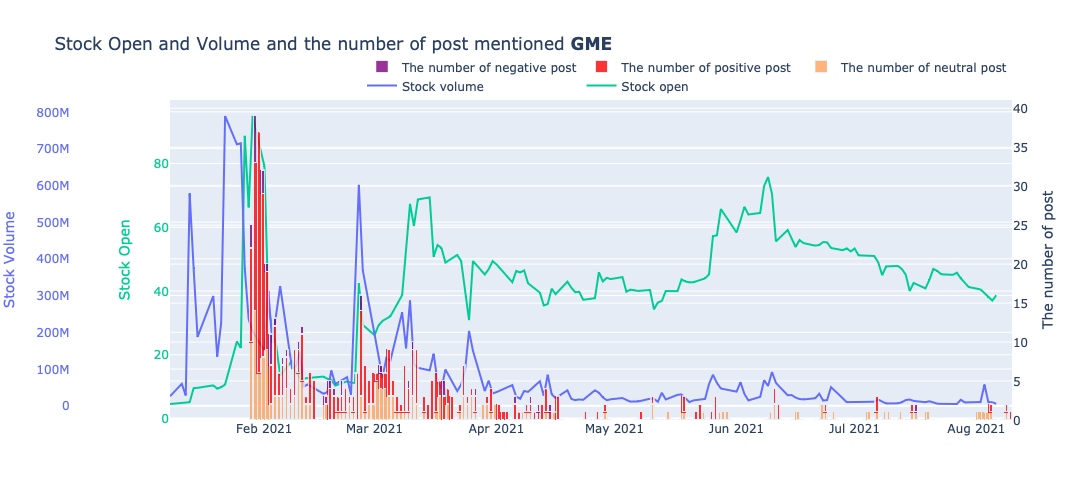

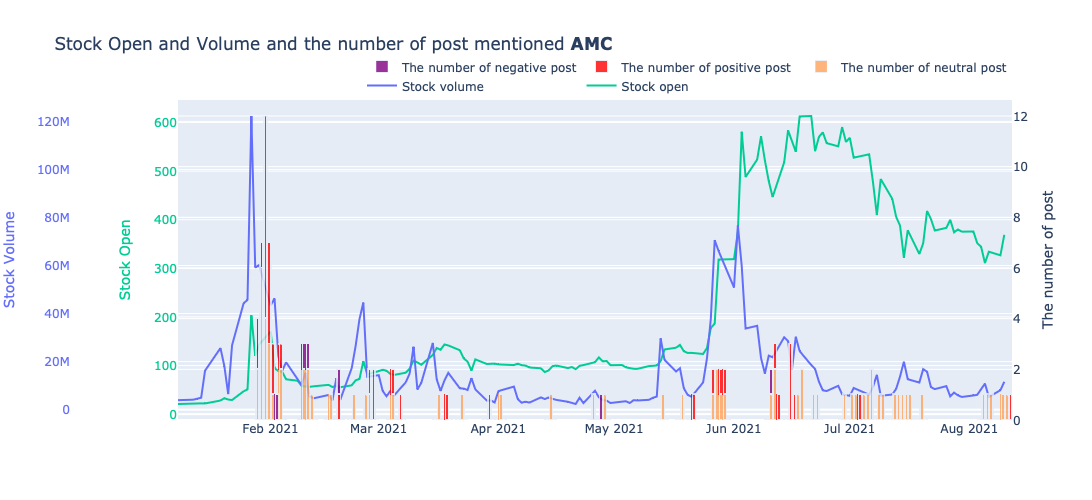

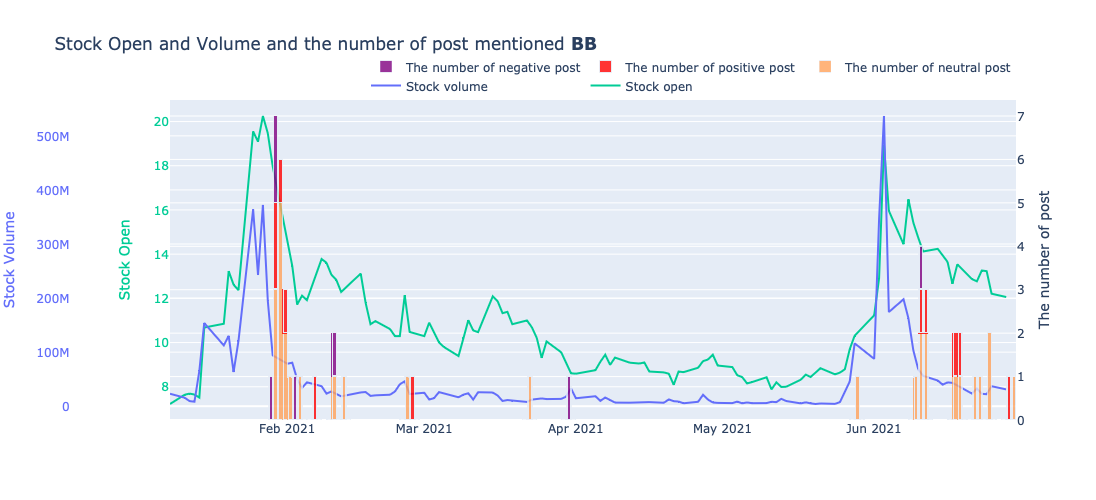

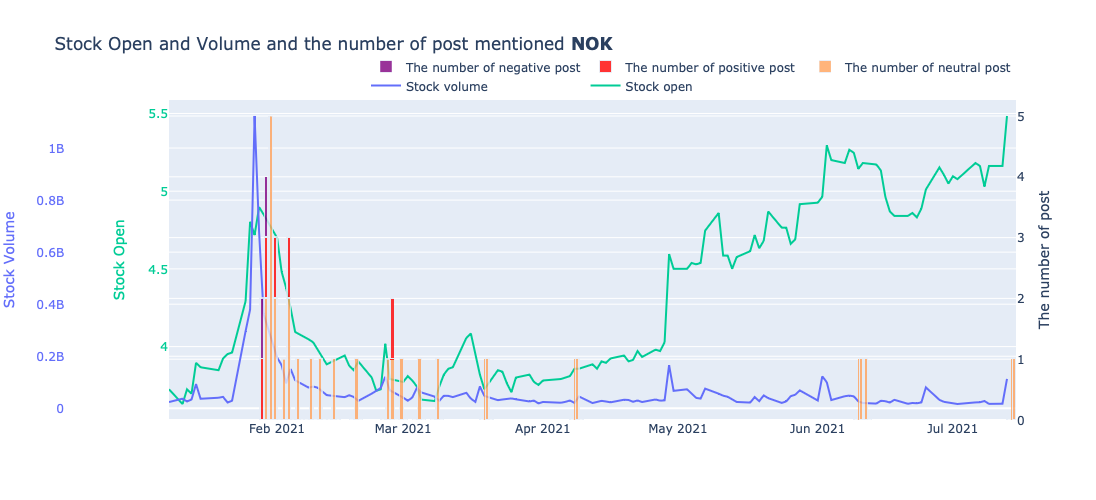

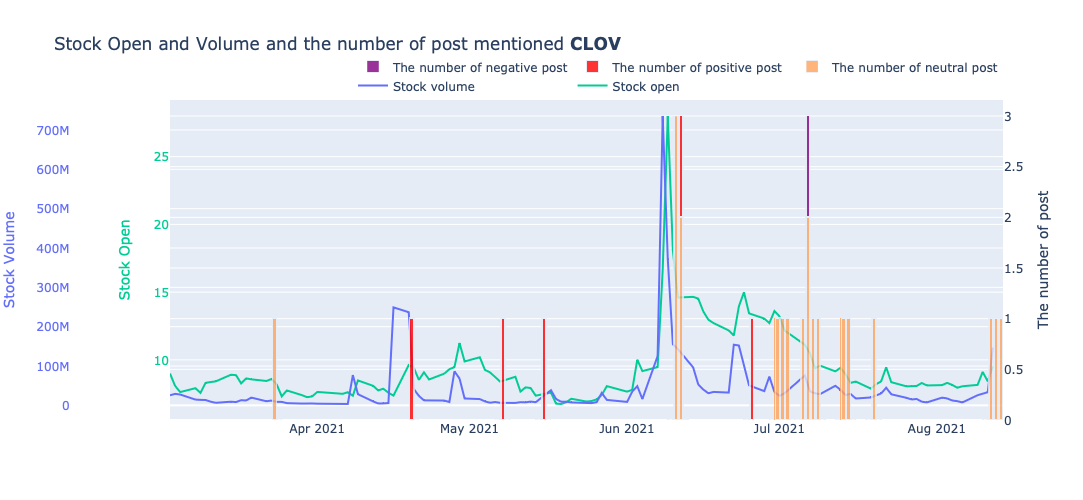

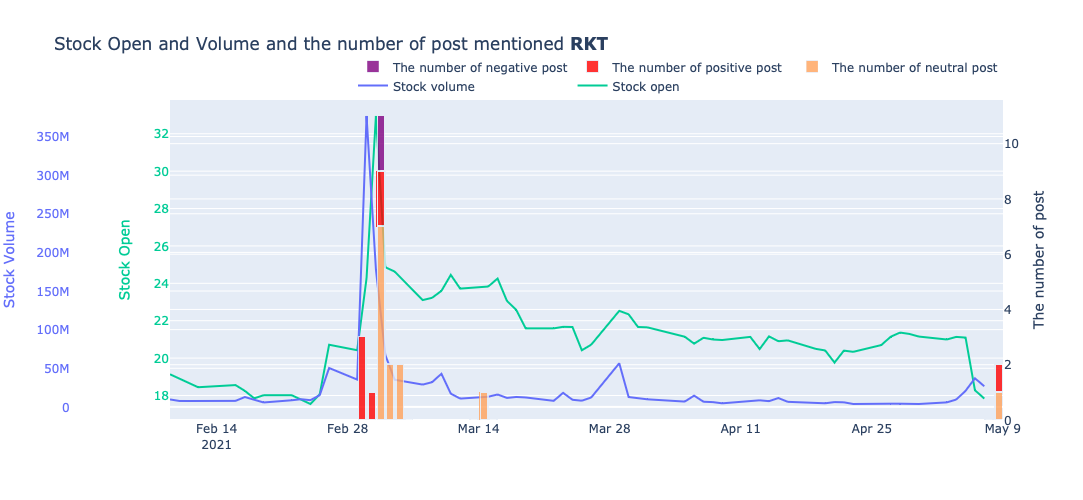

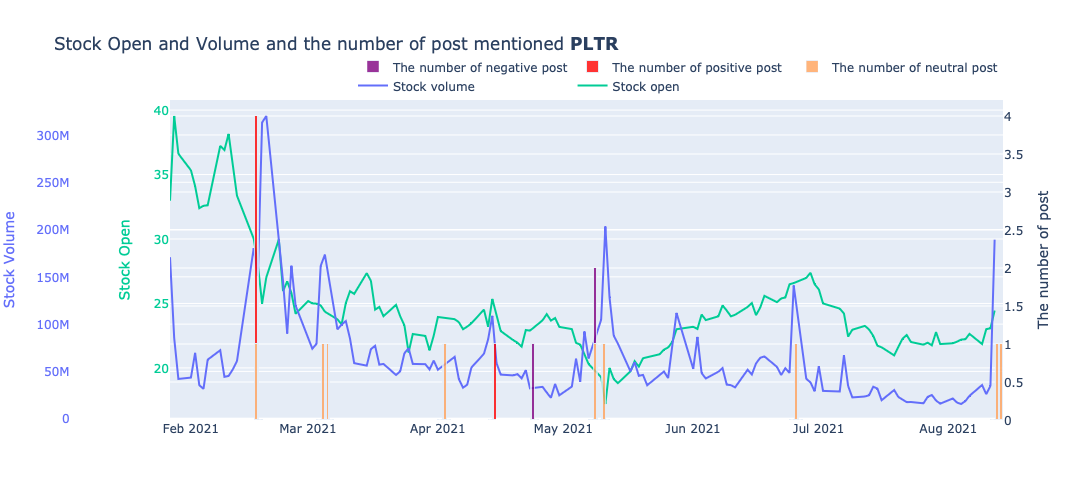

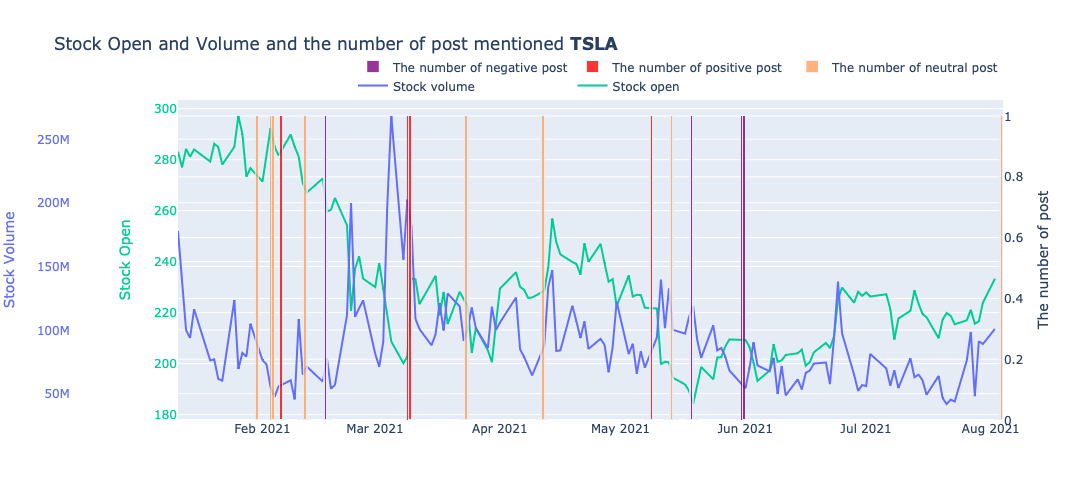

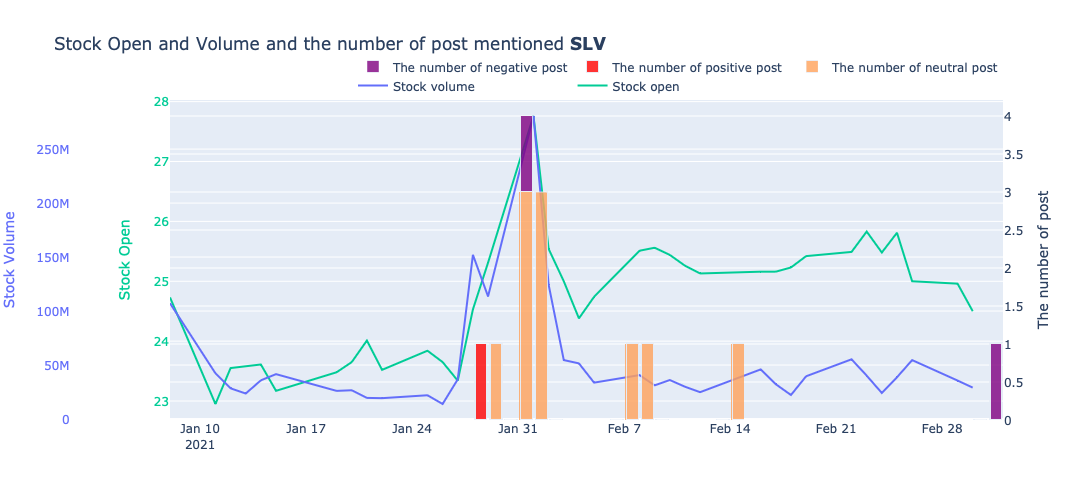

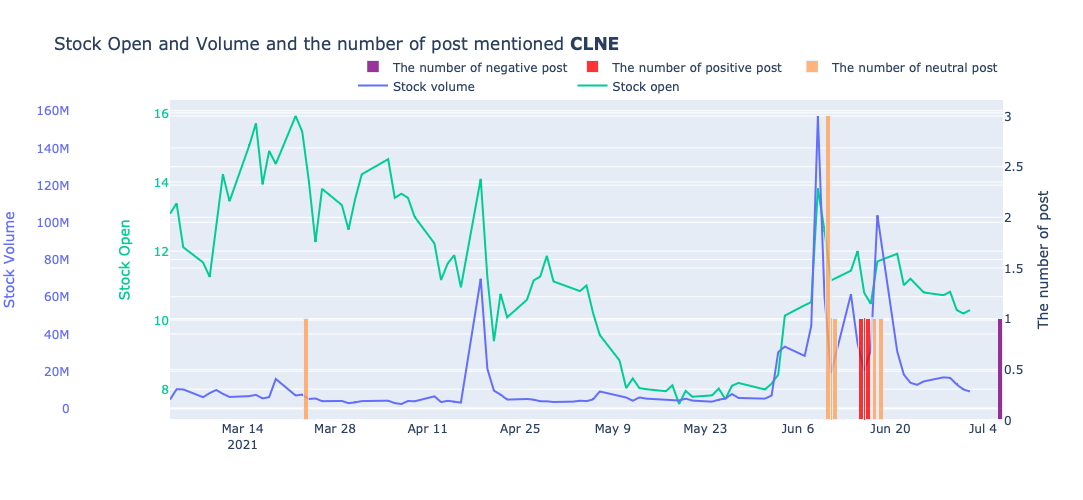

In [221]:
for ticker_symbol in df_kaggle.columns[-10:].values:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

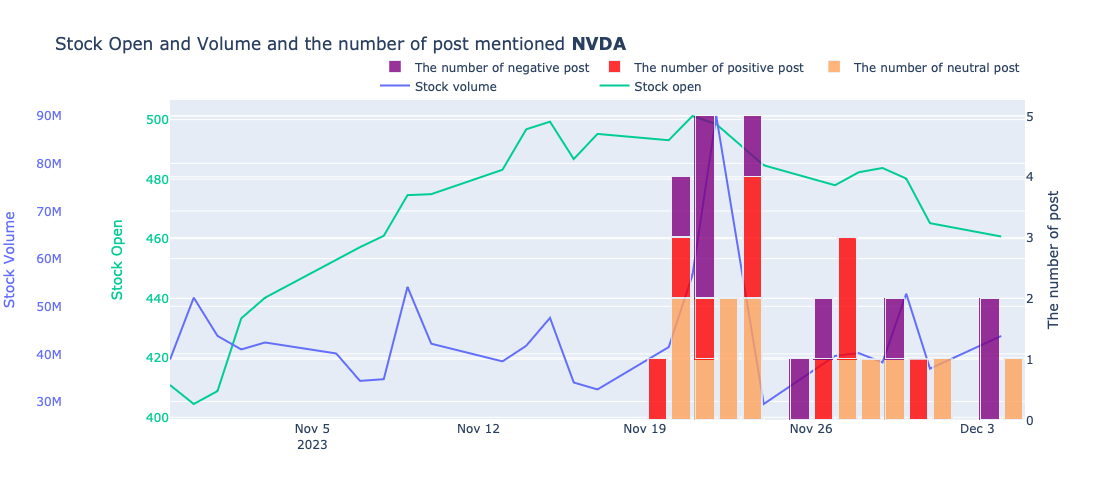

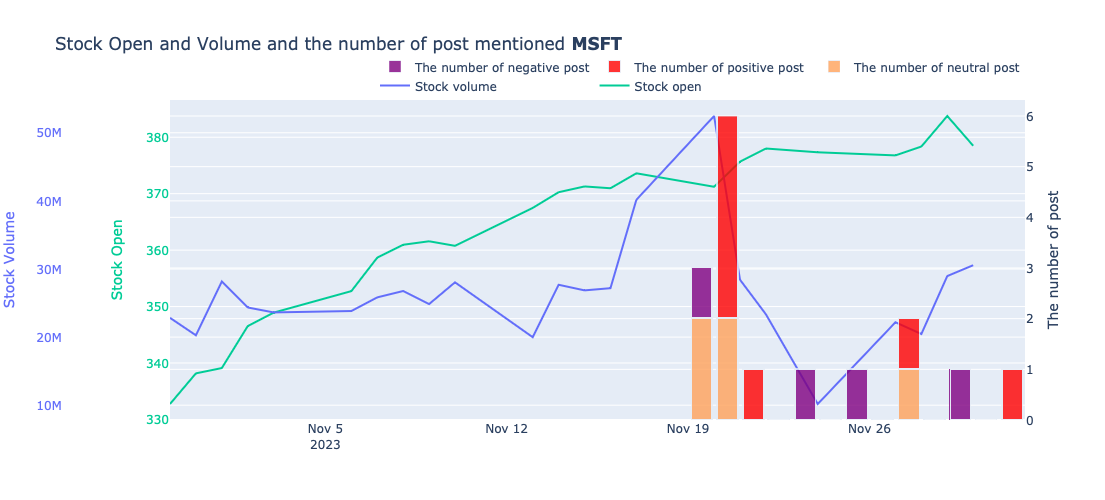

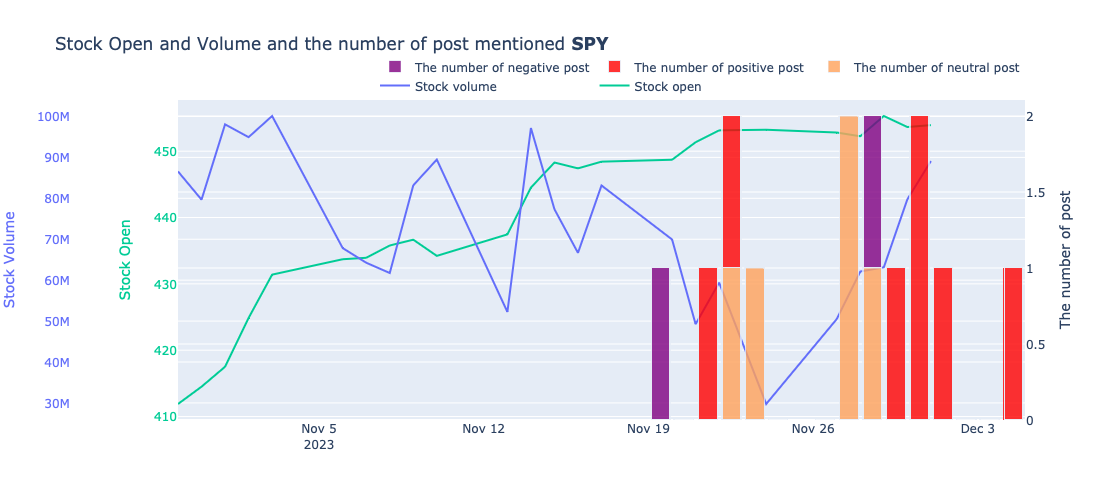

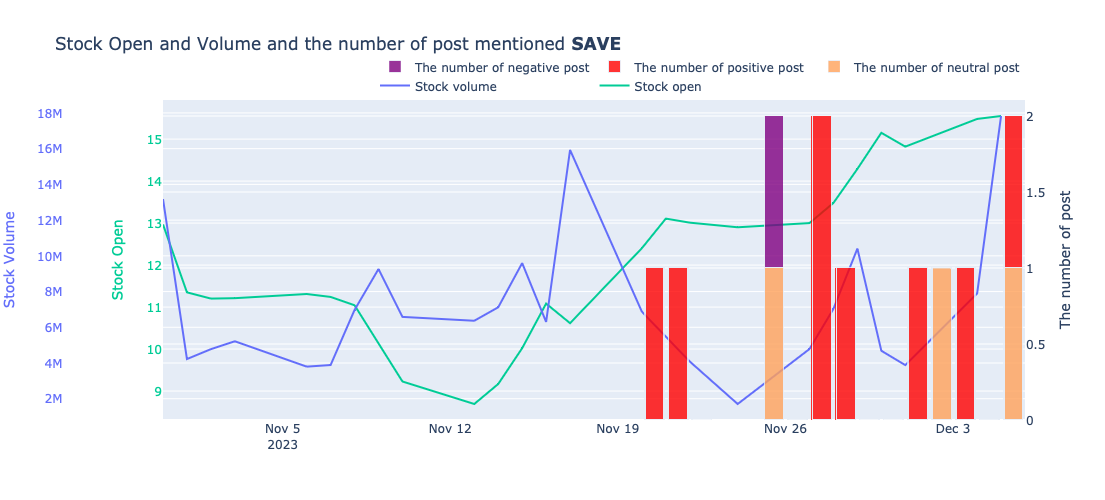

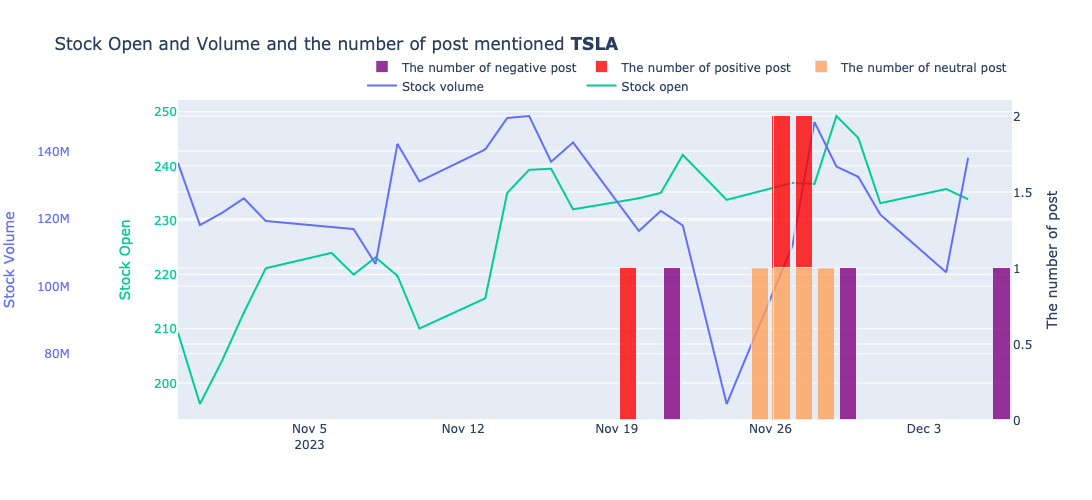

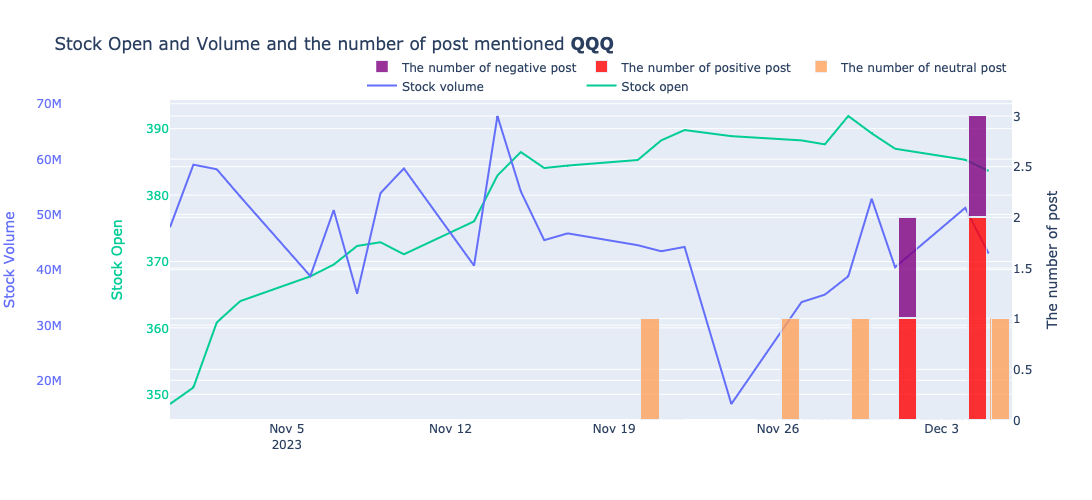

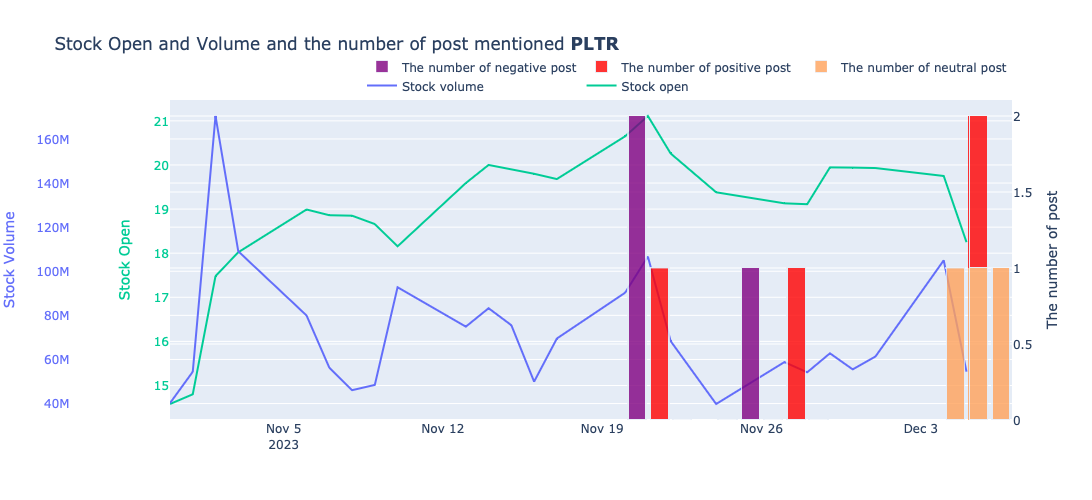

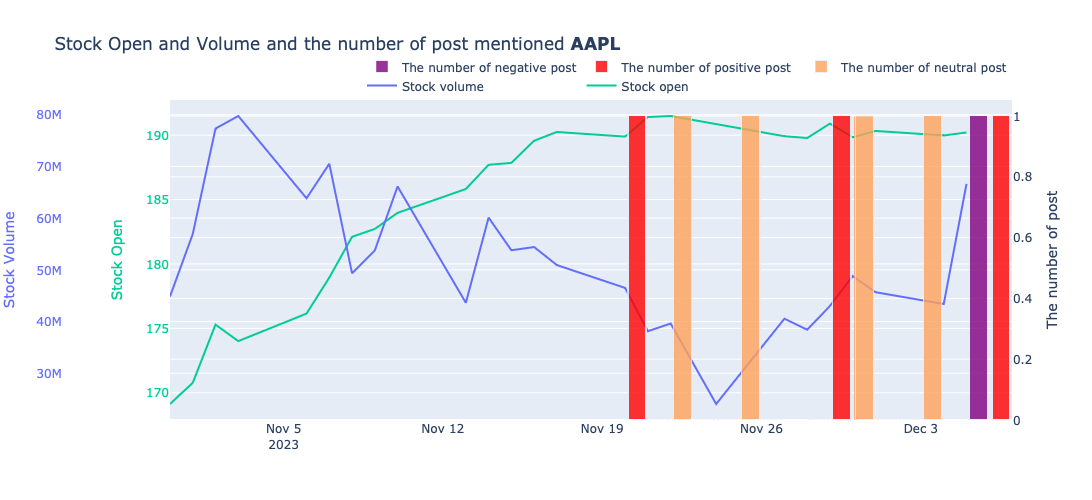

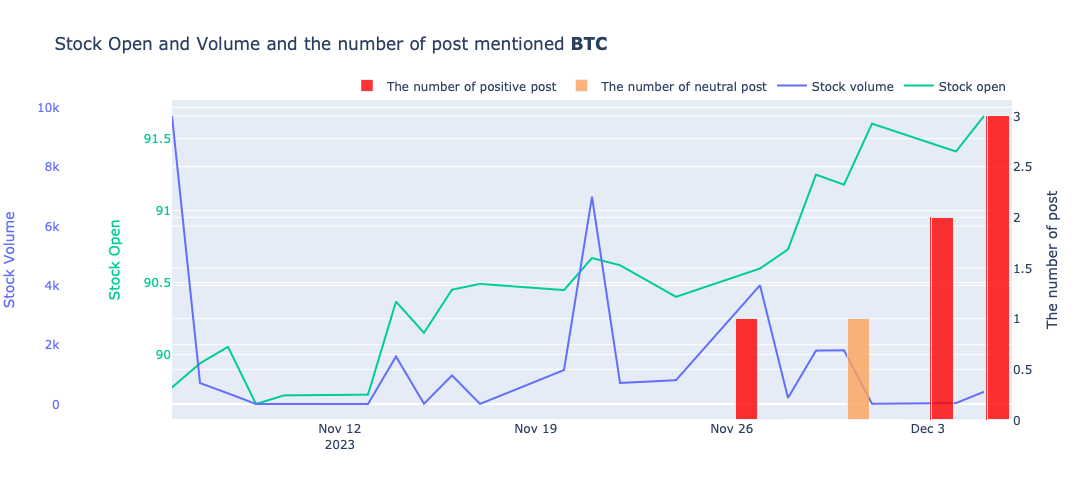

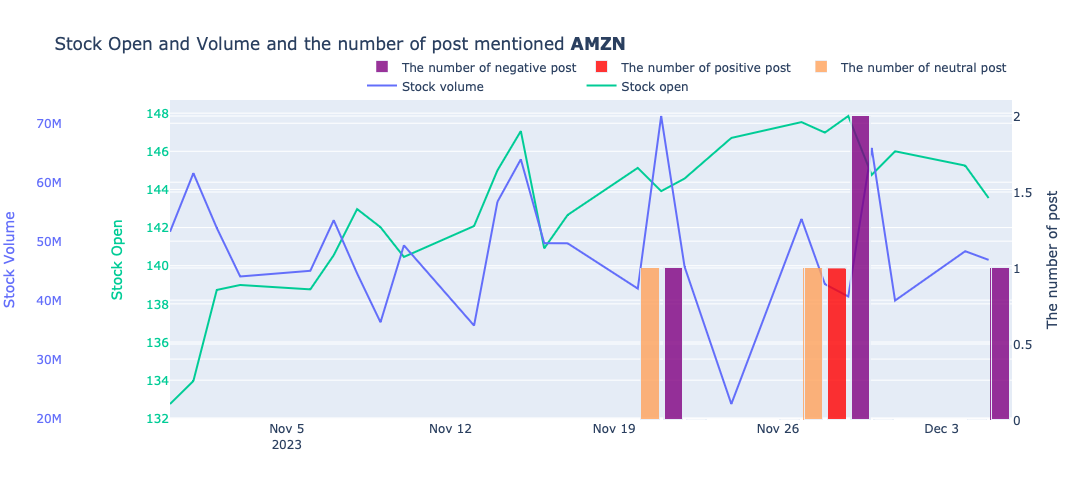

In [114]:
for ticker_symbol in df_2023.columns[-10:].values:
    plot_stock_and_post_freq(df_2023, ticker_symbol)

# Correlation

In [74]:
# stock_data should contain the data with a timestamp which is 1 interval later than end_time
def get_correlation(frequency_data, stock_data, start_time, end_time, mode="all", shift=timedelta(days=0), show_plot=False):
    if mode == "all":
        open_func = abs
    elif mode == "positive":
        open_func = operator.pos
    elif mode == "negative":
        open_func = operator.neg
    else:
        raise ValueError("Wrong mode")

    selected_frequency_data = frequency_data.loc[(frequency_data["timestamp"] >= start_time) & (frequency_data["timestamp"] < end_time)]
    selected_stock_data = stock_data.loc[(stock_data.index.tz_localize(None) >= start_time+shift) & (stock_data.index.tz_localize(None) < end_time+shift+(stock_data.index[1]-stock_data.index[0]))]
    if len(selected_frequency_data) == 0:
        raise ValueError(f"No freqency data in range of [{start_time+shift}, {end_time+shift})")
    if len(selected_stock_data) == 0:
        raise ValueError(f"No stock data in range of [{start_time+shift}, {end_time+shift})")
    elif len(selected_stock_data) == 1:
        raise ValueError(f"Stock data should contain at least 2 data in range of [{start_time+shift}, {end_time+shift})")

    # due to stock_data has no data during weekend, get a new frequency data
    stock_time = [time.date() for time in selected_stock_data.index[:-1]]
    new_freq = []
    cumulative_freq = 0
    i = 0
    for time in stock_time:
        if i >= len(selected_frequency_data["timestamp"]) or selected_frequency_data["timestamp"].iloc[i].date() > time:
            new_freq.append(0)
        else:
            cumulative_freq += selected_frequency_data["frequency"].iloc[i]
            i += 1
            while i < len(selected_frequency_data["timestamp"]) and selected_frequency_data["timestamp"].iloc[i].date() <= time:
                cumulative_freq += selected_frequency_data["frequency"].iloc[i]
                i += 1
            new_freq.append(cumulative_freq)
            cumulative_freq = 0

    # get difference between the next day open and today open
    new_open = []
    for i in range(0, len(selected_stock_data["Open"])-1):
        new_open.append(open_func(selected_stock_data["Open"].iloc[i+1] - selected_stock_data["Open"].iloc[i]))

    new_volume = []
    for i in range(0, len(selected_stock_data["Volume"])-1):
        new_volume.append(abs(selected_stock_data["Volume"].iloc[i+1] - selected_stock_data["Volume"].iloc[i]))

    if show_plot:
        # visualise relationship
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=new_freq,
            y=new_open,
            mode="markers"
        ))
        fig.update_layout(
            title_text="Correlation between Post Frequency and Open Price Difference",
            xaxis_title="number of posts",
            yaxis_title="open price differnce"
        )
        fig.show()
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=new_freq,
            y=new_volume,
            mode="markers"
        ))
        fig.update_layout(
            title_text="Correlation between Post Frequency and Volume Difference",
            xaxis_title="number of posts",
            yaxis_title="volume differnce"
        )
        fig.show()
    
    # calculate correlation
    open_correlation = scipy.stats.spearmanr(new_freq, new_open)
    volume_correlation = scipy.stats.spearmanr(new_freq, new_volume)
    

    freq_start_time = selected_frequency_data["timestamp"].iloc[0].to_pydatetime()
    freq_end_time = selected_frequency_data["timestamp"].iloc[-1].to_pydatetime()
    stock_start_time = selected_stock_data.index[0].tz_localize(None).to_pydatetime()
    
    stock_end_time = selected_stock_data.index[-2].tz_localize(None).to_pydatetime()

    return {
        "post_freq_start_time": freq_start_time,
        "post_freq_end_time": freq_end_time,
        "stock_start_time": stock_start_time,
        "stock_end_time": stock_end_time,
        "stock_open_price_correlation": open_correlation,
        "stock_volume_correlation": volume_correlation
    }

In [75]:
def format_correlation_result(df, target_ticker_symbol, start_timeshift = 0, end_timeshift = 5):
    # Prepare dataset
    df = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_all = get_post_freq(df["timestamp"], interval)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=30)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    # reserve for timeshift
    end_date = (datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=30)).strftime("%Y-%m-%d")
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # dataframe output
    sentiment_mode_list = ["all", "positive", "negative"]
    index = pd.MultiIndex.from_tuples([(i, j) for i in sentiment_mode_list for j in ["Open", "Volume"]])
    df_result = pd.DataFrame(index = index).transpose().astype("object")
    df_result.index.rename("Timeshift", inplace = True)
    post_freq_threshold = df_freq_all["frequency"].median()
    timestamp = df_freq_all[df_freq_all["frequency"] > post_freq_threshold]["timestamp"]
    start_time, end_time = timestamp.iloc[0], timestamp.iloc[-1]
    for df_freq, sentiment_mode in zip([df_freq_all, df_freq_positive, df_freq_negative], sentiment_mode_list):
        # No data
        if len(timestamp) == 0:
            df_result.loc[:, sentiment_mode] = "nan (nan)"
        else:
            for timeshift in range(start_timeshift, end_timeshift + 1):
                # df
                try:
                    result = get_correlation(df_freq, df_stock, start_time, end_time, sentiment_mode, timedelta(days=timeshift))
                except:
                    df_result.loc[timeshift, sentiment_mode] = "nan (nan)"
                    continue
                df_result.loc[timeshift, sentiment_mode] = [
                    f"{round(result['stock_open_price_correlation'][0], 4)} ({round(result['stock_open_price_correlation'][1], 4)})", 
                    f"{round(result['stock_volume_correlation'][0], 4)} ({round(result['stock_volume_correlation'][1], 4)})"
                ]
                # df_result.loc[current_len, timeshift] = [result['stock_open_price_correlation'][0], result['stock_volume_correlation'][0]]

    return df_result

### Kaggle Dataset

In [76]:
df_kaggle_method1 = pd.read_csv("./dataset/intermediate_dataset/method1_analysis_result_kaggle.csv")

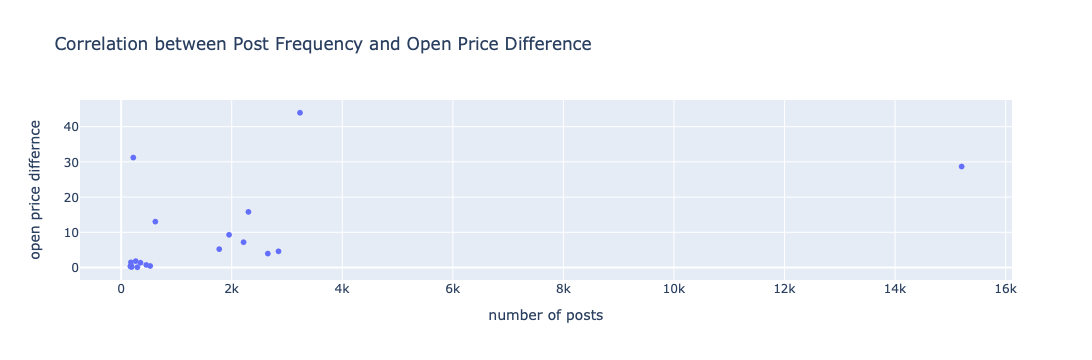

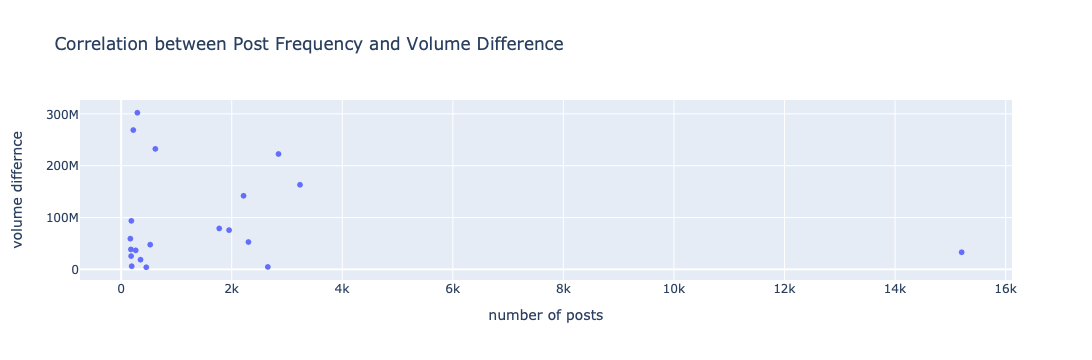

In [77]:
# Example
start_time = datetime.strptime(df_kaggle_method1["timestamp"][0].split(" ")[0], "%Y-%m-%d")
end_time = start_time + timedelta(days=30)
df_freq = get_post_freq(df_kaggle_method1["timestamp"], timedelta(days=1))
df_stock = yf.Ticker("GME").history(start = start_time, end = end_time, interval = "1d")
result = get_correlation(df_freq, df_stock, start_time, end_time, show_plot = True)

Method1

In [78]:
for ticker in df_kaggle_method1.columns[-11:-1]:
    print(f"============={ticker}================")
    df_result = format_correlation_result(df_kaggle_method1, ticker, start_timeshift = -2, end_timeshift = 2)
    display(df_result)

=============GME================


all                        positive                \
                      Open        Volume              Open        Volume   
Timeshift                                                                  
-2         0.3189 (0.0005)  0.5965 (0.0)  -0.0926 (0.3228)  0.5772 (0.0)   
-1         0.3378 (0.0002)  0.6345 (0.0)    -0.1033 (0.27)  0.6152 (0.0)   
 0         0.3139 (0.0006)  0.6364 (0.0)  -0.1437 (0.1238)  0.6177 (0.0)   
 1         0.2969 (0.0013)   0.631 (0.0)  -0.1212 (0.1968)  0.6119 (0.0)   
 2         0.2969 (0.0013)   0.631 (0.0)  -0.1212 (0.1968)  0.6119 (0.0)   

                  negative                
                      Open        Volume  
Timeshift                                 
-2          0.057 (0.5433)  0.5837 (0.0)  
-1          0.0802 (0.392)  0.6044 (0.0)  
 0         0.1185 (0.2052)  0.6064 (0.0)  
 1          0.096 (0.3073)  0.6002 (0.0)  
 2          0.096 (0.3073)  0.6002 (0.0)

=============AMC================


all                          positive                   \
                      Open           Volume             Open           Volume   
Timeshift                                                                       
-2          0.0469 (0.595)  0.3399 (0.0001)  0.0467 (0.5962)  0.3118 (0.0003)   
-1         0.0617 (0.4838)     0.3691 (0.0)  0.0365 (0.6788)  0.3397 (0.0001)   
 0         0.0428 (0.6278)     0.3734 (0.0)   0.008 (0.9273)  0.3448 (0.0001)   
 1         0.0317 (0.7207)     0.3609 (0.0)   -0.01 (0.9102)  0.3315 (0.0001)   
 2         0.0317 (0.7207)     0.3609 (0.0)   -0.01 (0.9102)  0.3315 (0.0001)   

                   negative                   
                       Open           Volume  
Timeshift                                     
-2         -0.1092 (0.2143)  0.3407 (0.0001)  
-1          -0.0959 (0.276)     0.3622 (0.0)  
 0         -0.0701 (0.4261)     0.3702 (0.0)  
 1         -0.0523 (0.5548)     0.3568 (0.0)  
 2         -0.0523 (0.5548)     0.3568 (0.0)

=============DD================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1384 (0.1383)  0.1884 (0.0428)  -0.1143 (0.2217)   
-1         0.1209 (0.1961)  0.1702 (0.0678)  -0.1146 (0.2207)   
 0         0.1109 (0.2359)    0.1492 (0.11)  -0.1532 (0.1007)   
 1         0.0869 (0.3555)   0.1271 (0.176)  -0.1305 (0.1644)   
 2         0.0869 (0.3555)   0.1271 (0.176)  -0.1305 (0.1644)   

                                    negative                   
                    Volume              Open           Volume  
Timeshift                                                      
-2         0.1698 (0.0684)  -0.0363 (0.6985)  0.2374 (0.0103)  
-1         0.1516 (0.1043)  -0.0367 (0.6957)  0.2229 (0.0162)  
 0          0.1342 (0.151)  -0.0073 (0.9381)  0.2011 (0.0304)  
 1         0.1117 (0.2348)  -0.0341 (0.7177)  0.1799 (0.0544)  
 2         0.1117 (0.2348)  -0.0341 (0.7177)  0.1799 (0.0544)

=============YOLO================


all                          positive                   \
                      Open           Volume             Open           Volume   
Timeshift                                                                       
-2         0.1858 (0.0468)  0.1938 (0.0379)  0.0633 (0.5016)   0.173 (0.0644)   
-1         0.1774 (0.0579)    0.21 (0.0243)  0.0538 (0.5679)  0.1884 (0.0438)   
 0          0.1773 (0.058)  0.2252 (0.0155)   0.066 (0.4834)   0.2037 (0.029)   
 1          0.2134 (0.022)   0.237 (0.0108)  0.0643 (0.4945)  0.2154 (0.0208)   
 2          0.2134 (0.022)   0.237 (0.0108)  0.0643 (0.4945)  0.2154 (0.0208)   

                   negative                   
                       Open           Volume  
Timeshift                                     
-2          -0.121 (0.1978)  0.2658 (0.0041)  
-1         -0.1119 (0.2337)  0.2814 (0.0023)  
 0         -0.1203 (0.2003)   0.294 (0.0014)  
 1         -0.1176 (0.2105)  0.3061 (0.0009)  
 2         -0.1176 (0.2105)  0.3061 (0.0009)

=============BB================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1778 (0.0669)  0.2586 (0.0072)  -0.1009 (0.3013)   
-1         0.1959 (0.0432)  0.2917 (0.0023)    -0.1196 (0.22)   
 0         0.1899 (0.0501)  0.2807 (0.0034)  -0.0961 (0.3248)   
 1         0.1676 (0.0859)  0.2685 (0.0054)    -0.07 (0.4756)   
 2         0.1676 (0.0859)  0.2685 (0.0054)    -0.07 (0.4756)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1985 (0.0404)  0.0974 (0.3185)   0.154 (0.1133)  
-1          0.2264 (0.019)   0.1106 (0.257)   0.176 (0.0697)  
 0         0.2143 (0.0267)  0.0839 (0.3903)    0.158 (0.104)  
 1          0.2008 (0.039)  0.0547 (0.5779)  0.1405 (0.1507)  
 2          0.2008 (0.039)  0.0547 (0.5779)  0.1405 (0.1507)

=============NOK================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1965 (0.0329)  0.2619 (0.0042)      -0.3 (0.001)   
-1         0.2127 (0.0207)  0.2854 (0.0017)   -0.276 (0.0025)   
 0          0.218 (0.0177)  0.2651 (0.0037)  -0.2678 (0.0034)   
 1         0.1836 (0.0466)  0.2552 (0.0053)  -0.2585 (0.0047)   
 2         0.1827 (0.0468)   0.252 (0.0057)   -0.2507 (0.006)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.2653 (0.0037)   0.1903 (0.039)  0.2428 (0.0081)  
-1         0.2829 (0.0019)   0.202 (0.0283)  0.2559 (0.0052)  
 0         0.2682 (0.0033)  0.1859 (0.0438)  0.2143 (0.0198)  
 1         0.2561 (0.0051)  0.1664 (0.0717)  0.1932 (0.0361)  
 2         0.2541 (0.0053)  0.1628 (0.0768)   0.192 (0.0365)

=============RH================


all                           positive  \
                       Open           Volume              Open   
Timeshift                                                        
-2          -0.012 (0.8917)  0.0165 (0.8516)  -0.0621 (0.4813)   
-1          -0.012 (0.8917)    0.018 (0.838)  -0.0791 (0.3693)   
 0         -0.0215 (0.8072)  0.0088 (0.9202)  -0.1006 (0.2527)   
 1          -0.014 (0.8746)  0.0268 (0.7621)  -0.1101 (0.2122)   
 2          -0.014 (0.8746)  0.0268 (0.7621)  -0.1101 (0.2122)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.0406 (0.6449)  -0.0763 (0.3866)  -0.0268 (0.7611)  
-1         -0.0398 (0.6513)  -0.0632 (0.4735)  -0.0257 (0.7706)  
 0         -0.0526 (0.5507)  -0.0434 (0.6227)  -0.0407 (0.6446)  
 1         -0.0352 (0.6912)  -0.0358 (0.6856)  -0.0213 (0.8097)  
 2         -0.0352 (0.6912)  -0.0358 (0.6856)  -0.0213 (0.8097)

=============MOON================


all                            positive  \
                      Open            Volume              Open   
Timeshift                                                        
-2         0.1863 (0.0443)   0.0016 (0.9859)  -0.0001 (0.9995)   
-1         0.1953 (0.0349)  -0.0009 (0.9927)   0.0086 (0.9267)   
 0         0.1858 (0.0459)    0.007 (0.9409)   0.0274 (0.7701)   
 1         0.2073 (0.0262)    0.031 (0.7421)   0.0208 (0.8253)   
 2         0.1962 (0.0348)   0.0485 (0.6053)   0.0356 (0.7042)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.0094 (0.9201)   0.0068 (0.9418)  -0.0234 (0.8025)  
-1         -0.0123 (0.8949)  -0.0027 (0.9773)  -0.0291 (0.7554)  
 0          -0.0046 (0.961)  -0.0222 (0.8128)  -0.0211 (0.8217)  
 1          0.0191 (0.8391)  -0.0153 (0.8708)   0.0028 (0.9765)  
 2           0.0363 (0.699)  -0.0257 (0.7842)   0.0156 (0.8677)

=============PLTR================


all                           positive                  \
                   Open           Volume              Open          Volume   
Timeshift                                                                    
-2         0.3876 (0.0)     0.3639 (0.0)  -0.1867 (0.0295)    0.3689 (0.0)   
-1         0.4119 (0.0)     0.3801 (0.0)  -0.1728 (0.0442)    0.3809 (0.0)   
 0            0.4 (0.0)  0.3349 (0.0001)   -0.1755 (0.041)  0.329 (0.0001)   
 1         0.3918 (0.0)     0.3599 (0.0)  -0.1614 (0.0614)    0.3522 (0.0)   
 2         0.3918 (0.0)     0.3599 (0.0)  -0.1614 (0.0614)    0.3522 (0.0)   

                  negative                   
                      Open           Volume  
Timeshift                                    
-2         0.1263 (0.1429)  0.2448 (0.0041)  
-1         0.1236 (0.1518)  0.2434 (0.0043)  
 0         0.1172 (0.1744)  0.1998 (0.0197)  
 1         0.0983 (0.2569)  0.2245 (0.0088)  
 2         0.0983 (0.2569)  0.2245 (0.0088)

=============EDIT================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.2084 (0.0169)  0.2904 (0.0008)  -0.0431 (0.6246)   
-1         0.2107 (0.0157)  0.2982 (0.0005)  -0.0355 (0.6876)   
 0         0.2113 (0.0154)  0.2637 (0.0023)  -0.0551 (0.5316)   
 1         0.2204 (0.0117)  0.2794 (0.0013)  -0.0657 (0.4575)   
 2         0.2204 (0.0117)  0.2794 (0.0013)  -0.0657 (0.4575)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2          0.2848 (0.001)  0.0716 (0.4166)  0.2878 (0.0009)  
-1         0.2949 (0.0006)  0.0728 (0.4088)  0.2863 (0.0009)  
 0         0.2613 (0.0026)  0.0884 (0.3152)  0.2557 (0.0032)  
 1          0.277 (0.0014)  0.1002 (0.2569)  0.2713 (0.0018)  
 2          0.277 (0.0014)  0.1002 (0.2569)  0.2713 (0.0018)

Method2

In [96]:
df_kaggle_method2 = pd.read_csv("./dataset/intermediate_dataset/method2_analysis_result_kaggle.csv")

In [97]:
for ticker in df_kaggle_method2.columns[-10:]:
    print(f"============={ticker}================")
    df_result = format_correlation_result(df_kaggle_method2, ticker, start_timeshift = -2, end_timeshift = 2)
    display(df_result)

=============GME================


all                        positive                \
                      Open        Volume              Open        Volume   
Timeshift                                                                  
-2         0.3479 (0.0007)  0.6089 (0.0)  -0.1113 (0.2909)  0.5885 (0.0)   
-1         0.3707 (0.0003)  0.6385 (0.0)  -0.1195 (0.2565)  0.6077 (0.0)   
 0         0.3229 (0.0017)  0.6328 (0.0)  -0.1314 (0.2119)   0.604 (0.0)   
 1         0.3012 (0.0037)  0.6292 (0.0)  -0.1017 (0.3374)  0.6002 (0.0)   
 2         0.3012 (0.0037)  0.6292 (0.0)  -0.1017 (0.3374)  0.6002 (0.0)   

                  negative                
                      Open        Volume  
Timeshift                                 
-2         0.2486 (0.0169)  0.4371 (0.0)  
-1          0.2528 (0.015)  0.4482 (0.0)  
 0         0.2885 (0.0053)  0.4497 (0.0)  
 1         0.2582 (0.0135)  0.4444 (0.0)  
 2         0.2582 (0.0135)  0.4444 (0.0)

=============AMC================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1165 (0.2277)  0.1723 (0.0732)    0.0219 (0.821)   
-1         0.1296 (0.1794)  0.1866 (0.0521)   0.0122 (0.8999)   
 0          0.1234 (0.201)  0.2035 (0.0338)  -0.0174 (0.8573)   
 1         0.0957 (0.3224)   0.1787 (0.063)  -0.0065 (0.9465)   
 2         0.0838 (0.3841)  0.1702 (0.0755)  -0.0133 (0.8907)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1752 (0.0684)  0.0565 (0.5594)  0.0921 (0.3409)  
-1         0.1857 (0.0532)   0.0632 (0.514)  0.0976 (0.3126)  
 0          0.1787 (0.063)  0.1075 (0.2657)   0.1378 (0.153)  
 1          0.185 (0.0541)  0.2197 (0.0217)  0.0799 (0.4089)  
 2           0.18 (0.0599)  0.2207 (0.0205)   0.0782 (0.417)

=============BB================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.3102 (0.0014)  0.3304 (0.0006)   -0.142 (0.1504)   
-1         0.3164 (0.0011)  0.3424 (0.0004)  -0.1467 (0.1372)   
 0         0.2946 (0.0024)  0.3101 (0.0014)  -0.1084 (0.2735)   
 1         0.2647 (0.0066)  0.2966 (0.0022)  -0.0519 (0.6008)   
 2         0.2681 (0.0057)  0.2996 (0.0019)   -0.0523 (0.596)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1177 (0.2339)  0.2986 (0.0021)  0.2503 (0.0104)  
-1         0.1237 (0.2108)  0.3026 (0.0018)  0.2572 (0.0084)  
 0         0.1593 (0.1063)  0.2646 (0.0066)  0.2094 (0.0329)  
 1           0.1325 (0.18)  0.2613 (0.0074)  0.1252 (0.2054)  
 2         0.1353 (0.1687)  0.2612 (0.0071)  0.1271 (0.1963)

=============NOK================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.0887 (0.3457)  0.2795 (0.0025)  -0.2518 (0.0066)   
-1         0.0887 (0.3457)  0.2818 (0.0023)  -0.2518 (0.0066)   
 0          0.0888 (0.345)  0.2492 (0.0072)  -0.2435 (0.0087)   
 1          0.066 (0.4837)  0.2187 (0.0189)  -0.1978 (0.0341)   
 2          0.066 (0.4837)  0.2187 (0.0189)  -0.1978 (0.0341)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.2941 (0.0014)  0.1543 (0.0997)  0.2224 (0.0169)  
-1         0.2967 (0.0013)  0.1543 (0.0997)   0.2264 (0.015)  
 0         0.2551 (0.0059)  0.1467 (0.1177)   0.1608 (0.086)  
 1          0.2037 (0.029)  0.1552 (0.0977)    0.11 (0.2417)  
 2          0.2037 (0.029)  0.1552 (0.0977)    0.11 (0.2417)

=============CLOV================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.2051 (0.0407)  0.1756 (0.0806)   -0.035 (0.7298)   
-1          0.2123 (0.034)  0.1967 (0.0498)  -0.0302 (0.7655)   
 0         0.2298 (0.0221)  0.1608 (0.1119)  -0.0331 (0.7451)   
 1         0.2228 (0.0274)  0.1858 (0.0671)  -0.0377 (0.7124)   
 2         0.2138 (0.0345)  0.1631 (0.1086)  -0.0311 (0.7608)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1248 (0.2161)  0.1132 (0.2623)  0.1132 (0.2623)  
-1           0.12 (0.2343)  0.1097 (0.2774)  0.1097 (0.2774)  
 0          0.1194 (0.239)  0.1096 (0.2803)  0.1096 (0.2803)  
 1         0.1172 (0.2504)  0.1131 (0.2677)  0.1095 (0.2833)  
 2         0.1172 (0.2504)  0.1131 (0.2677)  0.1095 (0.2833)

=============RKT================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.3875 (0.0065)  0.4313 (0.0022)   0.1394 (0.3445)   
-1         0.3875 (0.0065)  0.4313 (0.0022)   0.1394 (0.3445)   
 0         0.3272 (0.0248)  0.3727 (0.0099)   0.0076 (0.9595)   
 1          0.2381 (0.107)  0.2897 (0.0482)    -0.25 (0.0901)   
 2         0.1239 (0.4067)  0.1969 (0.1846)  -0.0652 (0.6632)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2          0.4194 (0.003)    0.2474 (0.09)  0.2264 (0.1218)  
-1          0.4194 (0.003)    0.2474 (0.09)  0.2264 (0.1218)  
 0          0.3498 (0.016)    0.25 (0.0901)  0.2391 (0.1055)  
 1           0.25 (0.0901)    0.25 (0.0901)    0.25 (0.0901)  
 2         0.2283 (0.1228)  0.0652 (0.6632)  0.2283 (0.1228)

=============PLTR================


all                           positive  \
                      Open           Volume              Open   
Timeshift                                                       
-2         0.1554 (0.0849)  0.2571 (0.0039)  -0.1968 (0.0285)   
-1          0.1469 (0.102)  0.2863 (0.0012)  -0.1962 (0.0283)   
 0          0.157 (0.0816)   0.313 (0.0004)  -0.2058 (0.0219)   
 1          0.1569 (0.083)  0.2511 (0.0051)   0.0071 (0.9379)   
 2         0.1681 (0.0631)  0.3194 (0.0003)   0.0126 (0.8902)   

                                   negative                   
                    Volume             Open           Volume  
Timeshift                                                     
-2         0.1482 (0.1004)   0.034 (0.7079)  0.0161 (0.8592)  
-1         0.1447 (0.1074)  0.0336 (0.7101)  0.0141 (0.8757)  
 0         0.1951 (0.0299)   0.034 (0.7079)  0.0143 (0.8747)  
 1          0.057 (0.5312)  0.0362 (0.6909)   0.0163 (0.858)  
 2         0.1957 (0.0301)  0.0344 (0.7056)   0.0163 (0.858)

=============TSLA================


all                           positive  \
                      Open            Volume             Open   
Timeshift                                                       
-2         0.0127 (0.8855)  -0.0439 (0.6199)   0.0635 (0.473)   
-1         0.0163 (0.8541)    -0.0389 (0.66)   0.0635 (0.473)   
 0         0.0163 (0.8541)    -0.0389 (0.66)   0.0635 (0.473)   
 1         0.0163 (0.8541)    -0.0389 (0.66)   0.0635 (0.473)   
 2         0.0255 (0.7734)    0.005 (0.9554)  0.0648 (0.4636)   

                                   negative                    
                    Volume             Open            Volume  
Timeshift                                                      
-2         0.0266 (0.7637)  0.1372 (0.1196)  -0.0307 (0.7286)  
-1          0.028 (0.7519)  0.1399 (0.1123)  -0.0266 (0.7637)  
 0          0.028 (0.7519)  0.1399 (0.1123)  -0.0266 (0.7637)  
 1          0.028 (0.7519)  0.1399 (0.1123)  -0.0266 (0.7637)  
 2          0.028 (0.7519)  0.1399 (0.1123)  -0.0266 (0.7637)

=============SLV================


all              positive              negative           
                Open     Volume       Open     Volume       Open     Volume
Timeshift                                                                  
-2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
-1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 0         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)

=============CLNE================


all              positive              negative           
                Open     Volume       Open     Volume       Open     Volume
Timeshift                                                                  
-2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
-1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 0         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)

### 2023 dataset

method1

In [122]:
df_2023_method1 = pd.read_csv("./dataset/intermediate_dataset/method1_analysis_result_2023.csv")

In [123]:
for ticker in df_2023_method1.columns[-11:-1]:
    print(f"============={ticker}================")
    df_result = format_correlation_result(df_2023_method1, ticker, start_timeshift = -2, end_timeshift = 2)
    display(df_result)

=============AI================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2         -0.6549 (0.0208)  -0.0106 (0.9739)  0.1324 (0.6816)   
-1         -0.4903 (0.0889)   -0.195 (0.5232)  0.2032 (0.5056)   
 0         -0.4903 (0.0889)   -0.195 (0.5232)  0.2032 (0.5056)   
 1          -0.4583 (0.134)  -0.2451 (0.4425)  0.3922 (0.2073)   
 2         -0.6095 (0.0354)  -0.3406 (0.2786)  0.0684 (0.8328)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.1288 (0.6899)    0.1543 (0.632)   0.1877 (0.5591)  
-1         -0.2794 (0.3553)   0.0975 (0.7513)   0.0706 (0.8187)  
 0         -0.2794 (0.3553)   0.0975 (0.7513)   0.0706 (0.8187)  
 1         -0.3599 (0.2506)  -0.0367 (0.9098)  -0.0184 (0.9548)  
 2         -0.3599 (0.2506)   0.0753 (0.8162)  -0.2204 (0.4912)

=============NVDA================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2           0.116 (0.8268)  -0.4058 (0.4247)  0.0294 (0.9559)   
-1          0.3273 (0.4736)   -0.2728 (0.554)  0.1101 (0.8142)   
 0         -0.1112 (0.8124)   0.0371 (0.9371)  0.4117 (0.3588)   
 1          0.3339 (0.5177)   0.0911 (0.8638)  0.0304 (0.9545)   
 2          0.3354 (0.5811)  -0.4472 (0.4502)  0.1118 (0.8579)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.2648 (0.6121)   0.1471 (0.7809)   0.0883 (0.8679)  
-1         -0.1652 (0.7234)         0.0 (1.0)   0.1101 (0.8142)  
 0         -0.0561 (0.9049)  -0.2994 (0.5142)   0.0748 (0.8733)  
 1          0.0911 (0.8638)   0.0617 (0.9075)   0.1543 (0.7704)  
 2         -0.4472 (0.4502)  -0.1118 (0.8579)  -0.4472 (0.4502)

=============MSFT================


all                          positive  \
                       Open           Volume             Open   
Timeshift                                                       
-2         -0.1325 (0.7544)  0.4338 (0.2829)  0.6596 (0.0752)   
-1         -0.1325 (0.7544)  0.4338 (0.2829)  0.6596 (0.0752)   
 0          -0.395 (0.2928)  0.6051 (0.0843)  0.7607 (0.0173)   
 1         -0.4874 (0.1832)  0.1933 (0.6183)  0.8453 (0.0041)   
 2         -0.8137 (0.0076)  0.5764 (0.1043)  0.3813 (0.3113)   

                                    negative                    
                    Volume              Open            Volume  
Timeshift                                                       
-2         0.3044 (0.4635)  -0.2965 (0.4758)   0.2594 (0.5349)  
-1         0.3044 (0.4635)  -0.2965 (0.4758)   0.2594 (0.5349)  
 0         0.5159 (0.1551)  -0.4129 (0.2694)   0.3689 (0.3285)  
 1          0.138 (0.7233)  -0.3578 (0.3444)  -0.0459 (0.9067)  
 2         0.5143 (0.1567)   -0.0275 (0.944)   0.3945 (0.2934)

=============U================


all                            positive  \
                       Open            Volume              Open   
Timeshift                                                         
-2         -0.3379 (0.3738)   0.2513 (0.5143)  -0.5078 (0.1628)   
-1         -0.5215 (0.1499)  -0.2308 (0.5501)  -0.6147 (0.0781)   
 0         -0.3163 (0.4069)   -0.0769 (0.844)  -0.5597 (0.1171)   
 1         -0.3323 (0.3823)   0.4022 (0.2832)  -0.3395 (0.3715)   
 2         -0.2465 (0.4923)    0.4282 (0.217)  -0.3633 (0.3022)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.1336 (0.7318)         nan (nan)         nan (nan)  
-1         -0.1336 (0.7318)  -0.1369 (0.7254)  -0.5477 (0.1269)  
 0          0.1009 (0.7961)  -0.1369 (0.7254)  -0.5477 (0.1269)  
 1          0.7615 (0.0171)  -0.1369 (0.7254)  -0.5477 (0.1269)  
 2          0.7677 (0.0095)   -0.058 (0.8735)  -0.5222 (0.1215)

=============SPY================


all                          positive  \
                       Open           Volume             Open   
Timeshift                                                       
-2                0.0 (1.0)  0.2503 (0.5499)  0.3546 (0.3888)   
-1                0.0 (1.0)  0.2503 (0.5499)  0.3546 (0.3888)   
 0          0.1725 (0.6572)   0.138 (0.7233)  0.4129 (0.2694)   
 1          0.3051 (0.4246)  0.0848 (0.8284)  0.5285 (0.1435)   
 2         -0.1026 (0.7928)   0.3505 (0.355)  0.0975 (0.8029)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2          -0.1091 (0.797)   0.0563 (0.8946)  -0.0563 (0.8946)  
-1          -0.1091 (0.797)   0.0563 (0.8946)  -0.0563 (0.8946)  
 0         -0.1835 (0.6365)         0.0 (1.0)  -0.0913 (0.8153)  
 1         -0.0433 (0.9119)  -0.0913 (0.8153)  -0.1826 (0.6382)  
 2          0.1685 (0.6648)   0.0913 (0.8153)   0.3651 (0.3339)

=============DM================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2          0.6325 (0.3675)   0.3162 (0.6838)        nan (nan)   
-1          0.7379 (0.1546)   0.2635 (0.6684)  0.3536 (0.5594)   
 0         -0.0294 (0.9559)  -0.2942 (0.5714)  0.3928 (0.4411)   
 1         -0.6473 (0.1646)   0.1471 (0.7809)  0.3928 (0.4411)   
 2         -0.5768 (0.2307)  -0.0304 (0.9545)  0.1309 (0.8047)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2                nan (nan)   0.6325 (0.3675)   0.2108 (0.7892)  
-1                0.0 (1.0)   0.6708 (0.2152)   0.1118 (0.8579)  
 0         -0.1309 (0.8047)  -0.0911 (0.8638)  -0.3947 (0.4387)  
 1         -0.1309 (0.8047)  -0.6789 (0.1381)   0.0309 (0.9537)  
 2          0.1309 (0.8047)  -0.3395 (0.5104)  -0.0617 (0.9075)

=============SAVE================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2          0.3664 (0.3322)   0.0396 (0.9194)  0.2661 (0.4889)   
-1          0.0546 (0.8809)   0.2936 (0.4103)    0.233 (0.517)   
 0          -0.506 (0.1356)    -0.1946 (0.59)  0.2335 (0.5161)   
 1         -0.3438 (0.3306)  -0.0259 (0.9433)  0.2829 (0.4283)   
 2         -0.2534 (0.4799)   0.1267 (0.7272)   0.329 (0.3533)   

                                    negative                   
                     Volume             Open           Volume  
Timeshift                                                      
-2                0.0 (1.0)  -0.1035 (0.791)  -0.1035 (0.791)  
-1          -0.0754 (0.836)        0.0 (1.0)  0.2697 (0.4511)  
 0         -0.3892 (0.2662)  0.1124 (0.7573)  0.0449 (0.9019)  
 1          -0.125 (0.7308)  0.3371 (0.3408)  0.1798 (0.6192)  
 2          0.0263 (0.9425)  0.3546 (0.3146)  0.2941 (0.4095)

=============E================


all                           positive  \
                       Open           Volume              Open   
Timeshift                                                        
-2         -0.6909 (0.0856)  -0.1802 (0.699)   -0.4685 (0.289)   
-1         -0.6013 (0.1148)  0.0488 (0.9087)   -0.1708 (0.686)   
 0         -0.2431 (0.5994)  0.3336 (0.4647)  -0.4077 (0.3639)   
 1          0.0294 (0.9559)  0.6377 (0.1731)   0.2899 (0.5774)   
 2         -0.2464 (0.6379)  0.1518 (0.7741)   0.5768 (0.2307)   

                             negative             
                    Volume       Open     Volume  
Timeshift                                         
-2         -0.1802 (0.699)  nan (nan)  nan (nan)  
-1         0.0488 (0.9087)  nan (nan)  nan (nan)  
 0         0.3336 (0.4647)  nan (nan)  nan (nan)  
 1         0.6377 (0.1731)  nan (nan)  nan (nan)  
 2         0.1518 (0.7741)  nan (nan)  nan (nan)

=============YOLO================


all                            positive  \
                      Open            Volume              Open   
Timeshift                                                        
-2         0.6728 (0.0976)  -0.3637 (0.4226)   0.1652 (0.7234)   
-1         0.6425 (0.0858)   -0.291 (0.4845)         0.0 (1.0)   
 0          0.491 (0.2632)  -0.7274 (0.0639)  -0.0374 (0.9365)   
 1         0.3479 (0.4993)  -0.8986 (0.0149)   -0.206 (0.6954)   
 2         -0.029 (0.9565)  -0.3189 (0.5379)  -0.5002 (0.3123)   

                                    negative                    
                     Volume             Open            Volume  
Timeshift                                                       
-2         -0.3855 (0.3931)        0.0 (1.0)  -0.1581 (0.7349)  
-1         -0.2718 (0.5149)  -0.126 (0.7663)   -0.126 (0.7663)  
 0         -0.7111 (0.0732)        0.0 (1.0)  -0.4743 (0.2822)  
 1         -0.8533 (0.0307)        0.0 (1.0)  -0.8281 (0.0418)  
 2         -0.2648 (0.6121)   0.207 (0.6939)   -0.207 (0.6939)

=============DD================


all                            positive  \
                       Open            Volume              Open   
Timeshift                                                         
-2         -0.6172 (0.1917)  -0.3086 (0.5518)  -0.7407 (0.0922)   
-1          -0.5379 (0.213)  -0.4183 (0.3503)  -0.7769 (0.0399)   
 0         -0.2474 (0.5546)  -0.1512 (0.7208)  -0.6461 (0.0835)   
 1          0.0891 (0.8494)   0.0891 (0.8494)  -0.8018 (0.0301)   
 2         -0.1352 (0.7984)   0.3719 (0.4679)  -0.3043 (0.5577)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.3086 (0.5518)   0.1309 (0.8047)  -0.6547 (0.1583)  
-1         -0.4183 (0.3503)   0.2041 (0.6606)  -0.6124 (0.1438)  
 0         -0.1512 (0.7208)   0.0825 (0.8461)    -0.4124 (0.31)  
 1          0.0891 (0.8494)   0.6124 (0.1438)  -0.2041 (0.6606)  
 2          0.3719 (0.4679)  -0.1309 (0.8047)   0.1309 (0.8047)

method2

In [118]:
df_2023_method2 = pd.read_csv("./dataset/intermediate_dataset/method2_analysis_result_2023.csv")

In [120]:
for ticker in df_2023_method2.columns[-10:]:
    print(f"============={ticker}================")
    df_result = format_correlation_result(df_2023_method2, ticker, start_timeshift = -2, end_timeshift = 2)
    display(df_result)

=============NVDA================


all                            positive  \
                       Open            Volume              Open   
Timeshift                                                         
-2         -0.0513 (0.9347)   0.0513 (0.9347)   0.2236 (0.7177)   
-1          0.4058 (0.4247)   0.4058 (0.4247)   0.1234 (0.8158)   
 0          0.3189 (0.5379)   0.4348 (0.3889)   0.0926 (0.8615)   
 1          0.3947 (0.4387)    0.2125 (0.686)  -0.1234 (0.8158)   
 2          0.3354 (0.5811)  -0.4472 (0.4502)   0.1118 (0.8579)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.6708 (0.2152)  -0.4617 (0.4338)  -0.3591 (0.5528)  
-1           -0.216 (0.681)  -0.2942 (0.5714)  -0.1177 (0.8243)  
 0         -0.0926 (0.8615)  -0.3947 (0.4387)  -0.1518 (0.7741)  
 1          0.1234 (0.8158)  -0.0304 (0.9545)   0.0911 (0.8638)  
 2         -0.4472 (0.4502)  -0.1118 (0.8579)  -0.4472 (0.4502)

=============MSFT================


all                        positive                  \
                     Open          Volume            Open          Volume   
Timeshift                                                                   
-2              1.0 (nan)       1.0 (nan)       1.0 (nan)       1.0 (nan)   
-1              1.0 (nan)       1.0 (nan)       1.0 (nan)       1.0 (nan)   
 0         0.866 (0.3333)  0.866 (0.3333)  0.866 (0.3333)  0.866 (0.3333)   
 1              1.0 (nan)      -1.0 (nan)       1.0 (nan)      -1.0 (nan)   
 2              nan (nan)       nan (nan)       nan (nan)       nan (nan)   

                  negative                  
                      Open          Volume  
Timeshift                                   
-2              -1.0 (nan)       1.0 (nan)  
-1              -1.0 (nan)       1.0 (nan)  
 0         -0.866 (0.3333)  0.866 (0.3333)  
 1              -1.0 (nan)      -1.0 (nan)  
 2               nan (nan)       nan (nan)

=============SPY================


all                            positive  \
                      Open            Volume              Open   
Timeshift                                                        
-2         0.2245 (0.6283)   0.1123 (0.8106)  -0.2227 (0.6312)   
-1         0.4414 (0.3809)         0.0 (1.0)  -0.0676 (0.8987)   
 0         0.4743 (0.4195)   0.1581 (0.7995)  -0.1118 (0.8579)   
 1         0.6172 (0.1917)   0.0617 (0.9075)  -0.0676 (0.8987)   
 2         0.8332 (0.0394)  -0.2469 (0.6372)  -0.0676 (0.8987)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.2227 (0.6312)  -0.6124 (0.1438)  -0.6124 (0.1438)  
-1         -0.2704 (0.6042)  -0.6547 (0.1583)  -0.6547 (0.1583)  
 0         -0.1118 (0.8579)  -0.7071 (0.1817)  -0.7071 (0.1817)  
 1         -0.2704 (0.6042)  -0.6547 (0.1583)  -0.6547 (0.1583)  
 2          0.1352 (0.7984)  -0.6547 (0.1583)  -0.6547 (0.1583)

=============SAVE================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2         -0.4781 (0.3375)   -0.239 (0.6483)  0.1852 (0.7254)   
-1         -0.6236 (0.1345)    0.0756 (0.872)  0.1157 (0.8048)   
 0         -0.5426 (0.2082)  -0.1684 (0.7181)  0.2315 (0.6175)   
 1         -0.3193 (0.4408)  -0.0639 (0.8806)  0.2999 (0.4704)   
 2         -0.1743 (0.6537)   0.1193 (0.7599)  0.3354 (0.3776)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2         -0.0617 (0.9075)   0.1309 (0.8047)  -0.3928 (0.4411)  
-1          0.0772 (0.8694)         0.0 (1.0)  -0.4082 (0.3632)  
 0           -0.27 (0.5581)         0.0 (1.0)  -0.4082 (0.3632)  
 1         -0.1304 (0.7582)  -0.0825 (0.8461)    -0.4124 (0.31)  
 2          0.0745 (0.8489)  -0.1369 (0.7254)  -0.2739 (0.4758)

=============TSLA================


all                        positive                  \
                      Open          Volume            Open          Volume   
Timeshift                                                                    
-2              -1.0 (nan)       1.0 (nan)      -1.0 (nan)       1.0 (nan)   
-1         -0.866 (0.3333)  0.866 (0.3333)       0.0 (1.0)  0.866 (0.3333)   
 0          0.866 (0.3333)  0.866 (0.3333)  0.866 (0.3333)  0.866 (0.3333)   
 1              -1.0 (nan)      -1.0 (nan)       1.0 (nan)      -1.0 (nan)   
 2               nan (nan)       nan (nan)       nan (nan)       nan (nan)   

            negative             
                Open     Volume  
Timeshift                        
-2         nan (nan)  nan (nan)  
-1         nan (nan)  nan (nan)  
 0         nan (nan)  nan (nan)  
 1         nan (nan)  nan (nan)  
 2         nan (nan)  nan (nan)

=============QQQ================


all              positive              negative           
                Open     Volume       Open     Volume       Open     Volume
Timeshift                                                                  
-2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
-1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 0         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)

=============PLTR================


all                            positive  \
                       Open            Volume              Open   
Timeshift                                                         
-2         -0.0685 (0.8611)  -0.3651 (0.3339)   -0.3105 (0.416)   
-1          0.1798 (0.6192)  -0.0449 (0.9019)  -0.1741 (0.6305)   
 0          0.3596 (0.3075)   0.1348 (0.7103)  -0.1899 (0.5992)   
 1          0.4495 (0.1925)   0.0449 (0.9019)  -0.3419 (0.3336)   
 2          0.1798 (0.6192)   0.1124 (0.7573)  -0.2659 (0.4577)   

                                     negative                    
                     Volume              Open            Volume  
Timeshift                                                        
-2          -0.1035 (0.791)  -0.3423 (0.3672)  -0.3651 (0.3339)  
-1         -0.1741 (0.6305)  -0.3719 (0.2899)  -0.3979 (0.2548)  
 0           -0.038 (0.917)   0.1211 (0.7389)  -0.2076 (0.5649)  
 1          -0.114 (0.7539)   0.2162 (0.5485)  -0.3027 (0.3952)  
 2           -0.038 (0.917)   0.0259 (0.9433)  -0.2249 (0.5322)

=============AAPL================


all                           positive  \
                       Open           Volume              Open   
Timeshift                                                        
-2          0.0711 (0.8453)   0.2843 (0.426)         0.0 (1.0)   
-1          0.1793 (0.5979)  0.3586 (0.2789)  -0.0745 (0.8276)   
 0         -0.2988 (0.3721)        0.0 (1.0)  -0.2981 (0.3732)   
 1         -0.1508 (0.6582)  0.1608 (0.6367)  -0.5217 (0.0997)   
 2                0.0 (1.0)  0.2814 (0.4309)  -0.6963 (0.0253)   

                                    negative                   
                    Volume              Open           Volume  
Timeshift                                                      
-2         0.1741 (0.6305)         nan (nan)        nan (nan)  
-1         0.0745 (0.8276)     -0.5 (0.1173)     0.5 (0.1173)  
 0         -0.3727 (0.259)     -0.5 (0.1173)     0.5 (0.1173)  
 1         0.0745 (0.8276)     -0.5 (0.1173)     0.5 (0.1173)  
 2         0.1741 (0.6305)  -0.5222 (0.1215)  0.5222 (0.1215)

=============BTC================


all                           positive  \
                       Open            Volume             Open   
Timeshift                                                        
-2         -0.1793 (0.7005)  -0.1793 (0.7005)  0.1782 (0.7023)   
-1          -0.1787 (0.672)  -0.0687 (0.8715)  0.1559 (0.7124)   
 0          -0.2888 (0.451)   -0.1096 (0.779)  0.2282 (0.5548)   
 1           0.165 (0.6963)   -0.165 (0.6963)  0.5923 (0.1218)   
 2         -0.1581 (0.7349)  -0.4743 (0.2822)  0.2227 (0.6312)   

                              negative             
                     Volume       Open     Volume  
Timeshift                                          
-2          0.2227 (0.6312)  nan (nan)  nan (nan)  
-1          0.3117 (0.4523)  nan (nan)  nan (nan)  
 0           0.251 (0.5147)  nan (nan)  nan (nan)  
 1          0.2026 (0.6303)  nan (nan)  nan (nan)  
 2         -0.4009 (0.3728)  nan (nan)  nan (nan)

=============AMZN================


all              positive              negative           
                Open     Volume       Open     Volume       Open     Volume
Timeshift                                                                  
-2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
-1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 0         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 1         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)
 2         nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)  nan (nan)

# Appendix

This appendix provide some trivial code that we already run it beforehand.

plot in three different figure

In [57]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    # df_neutral = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return

    fig_list = []
    for i in range(3):
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Open"],
                name = f"Stock open",
                marker=dict(color="#00CC96")
            )
        )
        
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Volume"],
                name = f"Stock volume",
                yaxis="y2",
                marker=dict(color="#636EFA")
            )
        )
        fig_list.append(fig)

    # color = ["#FFA15A", "red", "purple"]
    color = ["grey", "orange", "purple"]
    fig_list[0].add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color=color[0])
    ))
    fig_list[1].add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color=color[1])
    ))
    fig_list[2].add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.5,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color=color[2])
    ))

    # print(pd.Series(df_stock_date_list))
    # print(df_freq_positive["timestamp"])
    
    for i, fig in enumerate(fig_list):
        # Create axis objects
        fig.update_layout(
            yaxis=dict(
                title=f"Stock Open",
                titlefont=dict(
                    color="#00CC96"
                ),
                tickfont=dict(
                    color="#00CC96"
                )
            ),
            yaxis2=dict(
                title=f"Stock Volume",
                titlefont=dict(
                    color="#636EFA"
                ),
                tickfont=dict(
                    color="#636EFA"
                ),
                anchor="free",
                overlaying="y",
                side="left",
                autoshift=True,
                shift=-50,
            ),
            yaxis3=dict(
                title="The number of post",
                titlefont=dict(
                    color=color[i]
                ),
                tickfont=dict(
                    color=color[i]
                ),
                anchor="x",
                overlaying="y",
                side="right",
            ),
        )
        # Update layout properties
        fig.update_layout(
            title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
            width=1000,
            height=500,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    
        fig.show()
    # fig.write_html("test.html")